Data disponible ici: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
import warnings
import pprint
from IPython.display import clear_output

# Configuration

In [2]:
ROOT_INPUT = './data/original/'
ROOT_OUTPUT = './data/work/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()
pd.set_option('display.max_columns', 151)

# Fonctions

In [3]:
# Time tracking
@contextmanager
def timer(title: str):
    t0 = time.time()
    yield
    print("{} - éxécuté en {:.0f}s".format(title, time.time() - t0))

# Read and Sample CSV
def read(name: str, index: str = None, dates: [str] = []) -> pd.DataFrame:
    path = ROOT_INPUT + name
    print(f"Read file {path}")
    df = pd.read_csv(ROOT_INPUT + name, index_col=index, parse_dates= dates)
    print(f'{name} shape: {df.shape}')
    return df
    
# Graphe des taux de remplissage
def remplissage(df: pd.DataFrame, treshold: int = 101, ascending: bool = False):
    df_na = pd.DataFrame(((1- df.isna().mean()) * 100).round(0)).rename(columns={0: 'mean'})
    df_na = df_na[df_na['mean'] < treshold]
    ax = sns.barplot(data=df_na,
                     x='mean',
                     y=df_na.index,
                     palette='rainbow',
                     order=df_na.sort_values(by='mean', ascending=ascending).index)
    ax.bar_label(ax.containers[0], fmt='%.0f%%', padding=-35, c="white")
    plt.title(f'Taux de remplissage inférieur à {treshold} : {df_na.size} colonnes')
    plt.show()
        
def first_mode_num(x: pd.Series) -> float:
    mode = x.mode()
    if type(mode) is pd.Series:
        if mode.size > 0:
            return mode.iloc[0]
        else:
            return 0
    elif type(mode) is float:
        return x.mode()
    else:
        raise Exception('type error in first_mode fonction')

# Load DataFrames

In [4]:
df_infos = [
    {'file': 'olist_customers_dataset.csv',
     'index': 'customer_id',
     'name': 'customers', 
     'dates': []
    },
    {'file': 'olist_geolocation_dataset.csv',
     'index': 'geolocation_zip_code_prefix',
     'name': 'geolocation',
     'dates': []
    },
    {'file': 'olist_order_items_dataset.csv',
     'index': 'order_id',
     'name': 'order_items', 
     'dates': ['shipping_limit_date']
    },
    {'file': 'olist_order_payments_dataset.csv',
     'index': 'order_id',
     'name': 'order_payments',
     'dates': []
    },
    {'file': 'olist_order_reviews_dataset.csv',
     'index': 'review_id',
     'name': 'order_reviews',
     'dates': ['review_creation_date',
               'review_answer_timestamp'
              ]
    },
    {'file': 'olist_orders_dataset.csv',
     'index': 'order_id',
     'name': 'orders',
     'dates': ['order_purchase_timestamp',
               'order_approved_at',
               'order_delivered_carrier_date',
               'order_delivered_customer_date',
               'order_estimated_delivery_date'
              ]
    },
    {'file': 'olist_products_dataset.csv',
     'index': 'product_id',
     'name': 'products',
     'dates': []
    },
    {'file': 'olist_sellers_dataset.csv',
     'index': 'seller_id',
     'name': 'sellers',
     'dates': []
    },
    {'file': 'product_category_name_translation.csv',
     'index': 'product_category_name',
     'name': 'product_category_name_translation',
     'dates': []
    }
]

dfs: dict[str, pd.DataFrame] = {}

for info in df_infos:
    dfs[info['name']] = read(name=info['file'], index=info['index'], dates=info['dates'])
    print("")


# Copy originals dataFrames
df_customers = dfs['customers'].copy()
df_geolocation = dfs['geolocation'].copy()
df_order_items = dfs['order_items'].copy()
df_order_payments = dfs['order_payments'].copy()
df_order_reviews = dfs['order_reviews'].copy()
df_orders = dfs['orders'].copy()
df_products = dfs['products'].copy()
df_sellers = dfs['sellers'].copy()
df_product_category_name_translation = dfs['product_category_name_translation']


print('Les dataframes suivants sont chargés:')
pprint.pprint(list(dfs.keys()))

Read file ./data/original/olist_customers_dataset.csv
olist_customers_dataset.csv shape: (99441, 4)

Read file ./data/original/olist_geolocation_dataset.csv
olist_geolocation_dataset.csv shape: (1000163, 4)

Read file ./data/original/olist_order_items_dataset.csv
olist_order_items_dataset.csv shape: (112650, 6)

Read file ./data/original/olist_order_payments_dataset.csv
olist_order_payments_dataset.csv shape: (103886, 4)

Read file ./data/original/olist_order_reviews_dataset.csv
olist_order_reviews_dataset.csv shape: (99224, 6)

Read file ./data/original/olist_orders_dataset.csv
olist_orders_dataset.csv shape: (99441, 7)

Read file ./data/original/olist_products_dataset.csv
olist_products_dataset.csv shape: (32951, 8)

Read file ./data/original/olist_sellers_dataset.csv
olist_sellers_dataset.csv shape: (3095, 3)

Read file ./data/original/product_category_name_translation.csv
product_category_name_translation.csv shape: (71, 1)

Les dataframes suivants sont chargés:
['customers',
 'geo

# Aggregate DataFrames

## Aggregation de Geolocation dans Sellers et Customers

In [5]:
df_geolocation.head()

,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
geolocation_zip_code_prefix,,,,
1037,-23.545621,-46.639292,sao paulo,SP
1046,-23.546081,-46.644820,sao paulo,SP
1046,-23.546129,-46.642951,sao paulo,SP
1041,-23.544392,-46.639499,sao paulo,SP
1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
df_geolocation.index.has_duplicates

True

Les zip codes apparaissent plusieurs fois avec des données GPS différentes => Groupement par Zip code avec median des Longitude/Latitude avant aggrégation à Customers et Sellers

In [7]:
agg = {'geolocation_lat': 'median', 'geolocation_lng': 'median'}
df_geolocation = df_geolocation.groupby('geolocation_zip_code_prefix').agg(agg)
df_geolocation.head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550381,-46.634027
1002,-23.548551,-46.635072
1003,-23.548977,-46.635313
1004,-23.549535,-46.634771
1005,-23.549612,-46.636532


Ajout de Geolocation à Customers et Sellers. 

In [8]:
df_customers = df_customers.join(df_geolocation, on='customer_zip_code_prefix')
df_customers.rename(columns={'geolocation_lat': 'customer_geolocation_lat'}, inplace=True)
df_customers.rename(columns={'geolocation_lng': 'customer_geolocation_lng'}, inplace=True)
df_customers.drop(columns=['customer_zip_code_prefix', 'customer_city', 'customer_state'], inplace=True)

df_sellers = df_sellers.join(df_geolocation, on='seller_zip_code_prefix')
df_sellers.rename(columns={'geolocation_lat': 'seller_geolocation_lat'}, inplace=True)
df_sellers.rename(columns={'geolocation_lng': 'seller_geolocation_lng'}, inplace=True)
df_sellers.drop(columns=['seller_zip_code_prefix', 'seller_city', 'seller_state'], inplace=True)

## Aggrégation de Products, Sellers dans Orders_items

### Traitement Sellers

In [9]:
df_sellers.head()

,seller_geolocation_lat,seller_geolocation_lng
seller_id,,
3442f8959a84dea7ee197c632cb2df15,-22.894561,-47.062380
d1b65fc7debc3361ea86b5f14c68d2e2,-22.382440,-46.947605
ce3ad9de960102d0677a81f5d0bb7b2d,-22.909624,-43.176774
c0f3eea2e14555b6faeea3dd58c1b1c3,-23.657453,-46.612406
51a04a8a6bdcb23deccc82b0b80742cf,-22.964436,-46.535090


In [10]:
df_sellers.index.has_duplicates

False

Pas de traitement nécéssaire de Sellers avant aggrégation dans Order_items

### Traitement Products

In [11]:
df_products.head()

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [12]:
df_products.index.has_duplicates

False

Encodage de la catégorie en OneHot

In [13]:
df_products = pd.get_dummies(df_products, columns=['product_category_name'])

In [14]:
df_products

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,product_category_name_artigos_de_natal,product_category_name_audio,product_category_name_automotivo,product_category_name_bebes,product_category_name_bebidas,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_casa_conforto,product_category_name_casa_conforto_2,product_category_name_casa_construcao,product_category_name_cds_dvds_musicais,product_category_name_cine_foto,product_category_name_climatizacao,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_construcao_ferramentas_ferramentas,product_category_name_construcao_ferramentas_iluminacao,product_category_name_construcao_ferramentas_jardim,product_category_name_construcao_ferramentas_seguranca,product_category_name_cool_stuff,product_category_name_dvds_blu_ray,product_category_name_eletrodomesticos,product_category_name_eletrodomesticos_2,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_fashion_calcados,product_category_name_fashion_esporte,product_category_name_fashion_roupa_feminina,product_category_name_fashion_roupa_infanto_juvenil,product_category_name_fashion_roupa_masculina,product_category_name_fashion_underwear_e_moda_praia,product_category_name_ferramentas_jardim,product_category_name_flores,product_category_name_fraldas_higiene,product_category_name_industria_comercio_e_negocios,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_la_cuisine,product_category_name_livros_importados,product_category_name_livros_interesse_geral,product_category_name_livros_tecnicos,product_category_name_malas_acessorios,product_category_name_market_place,product_category_name_moveis_colchao_e_estofado,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_moveis_quarto,product_category_name_moveis_sala,product_category_name_musica,product_category_name_papelaria,product_category_name_pc_gamer,product_category_name_pcs,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

### Aggregation

In [15]:
df_order_items = df_order_items.join(df_sellers, on='seller_id', how='left')
df_order_items = df_order_items.join(df_products, on='product_id', how='left')

df_order_items

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_geolocation_lat,seller_geolocation_lng,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,product_category_name_artigos_de_natal,product_category_name_audio,product_category_name_automotivo,product_category_name_bebes,product_category_name_bebidas,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_casa_conforto,product_category_name_casa_conforto_2,product_category_name_casa_construcao,product_category_name_cds_dvds_musicais,product_category_name_cine_foto,product_category_name_climatizacao,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_construcao_ferramentas_ferramentas,product_category_name_construcao_ferramentas_iluminacao,product_category_name_construcao_ferramentas_jardim,product_category_name_construcao_ferramentas_seguranca,product_category_name_cool_stuff,product_category_name_dvds_blu_ray,product_category_name_eletrodomesticos,product_category_name_eletrodomesticos_2,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_fashion_calcados,product_category_name_fashion_esporte,product_category_name_fashion_roupa_feminina,product_category_name_fashion_roupa_infanto_juvenil,product_category_name_fashion_roupa_masculina,product_category_name_fashion_underwear_e_moda_praia,product_category_name_ferramentas_jardim,product_category_name_flores,product_category_name_fraldas_higiene,product_category_name_industria_comercio_e_negocios,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_la_cuisine,product_category_name_livros_importados,product_category_name_livros_interesse_geral,product_category_name_livros_tecnicos,product_category_name_malas_acessorios,product_category_name_market_place,product_category_name_moveis_colchao_e_estofado,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_moveis_quarto,product_category_name_moveis_sala,product_category_name_musica,product_category_name_papelaria,product_category_name_pc_gamer,product_category_name_pcs,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,-22.498419,-44.125272,58.0,598.0,4.0,650.0,28.0,9.0,14.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c

## Aggrégation de Order_items, Order_reviews, Order_payments dans Orders

### Traitement de Orders_items

In [16]:
df_order_items.head()

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_geolocation_lat,seller_geolocation_lng,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,product_category_name_artigos_de_natal,product_category_name_audio,product_category_name_automotivo,product_category_name_bebes,product_category_name_bebidas,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_casa_conforto,product_category_name_casa_conforto_2,product_category_name_casa_construcao,product_category_name_cds_dvds_musicais,product_category_name_cine_foto,product_category_name_climatizacao,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_construcao_ferramentas_ferramentas,product_category_name_construcao_ferramentas_iluminacao,product_category_name_construcao_ferramentas_jardim,product_category_name_construcao_ferramentas_seguranca,product_category_name_cool_stuff,product_category_name_dvds_blu_ray,product_category_name_eletrodomesticos,product_category_name_eletrodomesticos_2,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_fashion_calcados,product_category_name_fashion_esporte,product_category_name_fashion_roupa_feminina,product_category_name_fashion_roupa_infanto_juvenil,product_category_name_fashion_roupa_masculina,product_category_name_fashion_underwear_e_moda_praia,product_category_name_ferramentas_jardim,product_category_name_flores,product_category_name_fraldas_higiene,product_category_name_industria_comercio_e_negocios,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_la_cuisine,product_category_name_livros_importados,product_category_name_livros_interesse_geral,product_category_name_livros_tecnicos,product_category_name_malas_acessorios,product_category_name_market_place,product_category_name_moveis_colchao_e_estofado,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_moveis_quarto,product_category_name_moveis_sala,product_category_name_musica,product_category_name_papelaria,product_category_name_pc_gamer,product_category_name_pcs,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,-22.498419,-44.125272,58.0,598.0,4.0,650.0,28.0,9.0,14.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c

In [17]:
df_order_items.index.has_duplicates

True

Traitement nécéssaire pour aggreger Order_payments dans Orders:
1. Grouper par order_id

In [18]:
agg = {
    'product_id': 'count',
    'seller_id': 'count',
    'shipping_limit_date': 'max',
    'price': ['min', 'max', 'sum'],
    'freight_value': 'sum',
    'seller_geolocation_lat': 'mean',
    'seller_geolocation_lng': 'mean',
    'product_name_lenght': 'mean',
    'product_description_lenght': 'mean',
    'product_photos_qty': 'mean',
    'product_weight_g': 'sum',
    'product_length_cm': 'mean',
    'product_height_cm': 'mean',
    'product_width_cm': 'mean'
}

for cat in df_order_items.columns:
    if cat.startswith('product_category_name_'):
        agg[cat] = 'sum'

df_order_items = df_order_items.groupby(by='order_id').agg(agg)
df_order_items.columns = df_order_items.columns.map('_'.join).str.strip('_')
df_order_items

,product_id_count,seller_id_count,shipping_limit_date_max,price_min,price_max,price_sum,freight_value_sum,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_sum,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_category_name_agro_industria_e_comercio_sum,product_category_name_alimentos_sum,product_category_name_alimentos_bebidas_sum,product_category_name_artes_sum,product_category_name_artes_e_artesanato_sum,product_category_name_artigos_de_festas_sum,product_category_name_artigos_de_natal_sum,product_category_name_audio_sum,product_category_name_automotivo_sum,product_category_name_bebes_sum,product_category_name_bebidas_sum,product_category_name_beleza_saude_sum,product_category_name_brinquedos_sum,product_category_name_cama_mesa_banho_sum,product_category_name_casa_conforto_sum,product_category_name_casa_conforto_2_sum,product_category_name_casa_construcao_sum,product_category_name_cds_dvds_musicais_sum,product_category_name_cine_foto_sum,product_category_name_climatizacao_sum,product_category_name_consoles_games_sum,product_category_name_construcao_ferramentas_construcao_sum,product_category_name_construcao_ferramentas_ferramentas_sum,product_category_name_construcao_ferramentas_iluminacao_sum,product_category_name_construcao_ferramentas_jardim_sum,product_category_name_construcao_ferramentas_seguranca_sum,product_category_name_cool_stuff_sum,product_category_name_dvds_blu_ray_sum,product_category_name_eletrodomesticos_sum,product_category_name_eletrodomesticos_2_sum,product_category_name_eletronicos_sum,product_category_name_eletroportateis_sum,product_category_name_esporte_lazer_sum,product_category_name_fashion_bolsas_e_acessorios_sum,product_category_name_fashion_calcados_sum,product_category_name_fashion_esporte_sum,product_category_name_fashion_roupa_feminina_sum,product_category_name_fashion_roupa_infanto_juvenil_sum,product_category_name_fashion_roupa_masculina_sum,product_category_name_fashion_underwear_e_moda_praia_sum,product_category_name_ferramentas_jardim_sum,product_category_name_flores_sum,product_category_name_fraldas_higiene_sum,product_category_name_industria_comercio_e_negocios_sum,product_category_name_informatica_acessorios_sum,product_category_name_instrumentos_musicais_sum,product_category_name_la_cuisine_sum,product_category_name_livros_importados_sum,product_category_name_livros_interesse_geral_sum,product_category_name_livros_tecnicos_sum,product_category_name_malas_acessorios_sum,product_category_name_market_place_sum,product_category_name_moveis_colchao_e_estofado_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum,product_category_name_moveis_decoracao_sum,product_category_name_moveis_escritorio_sum,product_category_name_moveis_quarto_sum,product_category_name_moveis_sala_sum,product_category_name_musica_sum,product_category_name_papelaria_sum,product_category_name_pc_gamer_sum,product_category_name_pcs_sum,product_category_name_perfumaria_sum,product_category_name_pet_shop_sum,product_category_name_portateis_casa_forno_e_cafe_sum,product_category_name_portateis_cozinha_e_preparadores_de_alimentos_sum,product_category_name_relogios_presentes_sum,product_category_name_seguros_e_servicos_sum,product_category_name_sinalizacao_e_seguranca_sum,product_category_name_tablets_impressao_imagem_sum,product_category_name_telefonia_sum,product_category_name_telefonia_fixa_sum,product_category_name_utilidades_domesticas_sum
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,1,2017-09-19 09:45:35,58.90,58.90,58.90,13.29,-22.498419,-44.125272,58.0,598.0,4.0,650.0,28.0,9.0,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00018f77f2f0320c557190d7a144bdd3,1,1,2017-05-03 11:05:13,

### Traitement Order_payments

In [19]:
df_order_payments.head()

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
df_order_payments.index.has_duplicates

True

Traitement nécéssaire pour aggreger Order_payments dans Orders:
1. Encoder payment_type
2. Grouper par order_id

In [21]:
df_order_payments = pd.get_dummies(df_order_payments, columns=['payment_type'])

In [22]:
df_order_payments

,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
order_id,,,,,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,8,99.33,False,True,False,False,False
a9810da82917af2d9aefd1278f1dcfa0,1,1,24.39,False,True,False,False,False
25e8ea4e93396b6fa0d3dd708e76c1bd,1,1,65.71,False,True,False,False,False
ba78997921bbcdc1373bb41e913ab953,1,8,107.78,False,True,False,False,False
42fdf880ba16b47b59251dd489d4441a,1,2,128.45,False,True,False,False,False
...,...,...,...,...,...,...,...,...
0406037ad97740d563a178ecc7a2075c,1,1,363.31,True,False,False,False,False
7b905861d7c825891d6347454ea7863f,1,2,96.80,False,True,False,False,False
32609bbb3dd69b3c066a6860554a77bf,1,1,47.77,False,True,False,False,False


In [23]:
agg = {
    'payment_sequential': 'max',
    'payment_installments': 'max',
    'payment_value': 'sum',
    'payment_type_boleto': 'sum',
    'payment_type_credit_card': 'sum',
    'payment_type_debit_card': 'sum',
    'payment_type_not_defined': 'sum',
    'payment_type_voucher': 'sum'
}
df_order_payments = df_order_payments.groupby('order_id').agg(agg)

In [24]:
df_order_payments

,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
order_id,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19,0,1,0,0,0
00018f77f2f0320c557190d7a144bdd3,1,3,259.83,0,1,0,0,0
000229ec398224ef6ca0657da4fc703e,1,5,216.87,0,1,0,0,0
00024acbcdf0a6daa1e931b038114c75,1,2,25.78,0,1,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04,0,1,0,0,0
...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,1,343.40,1,0,0,0,0
fffcd46ef2263f404302a634eb57f7eb,1,1,386.53,1,0,0,0,0
fffce4705a9662cd70adb13d4a31832d,1,3,116.85,0,1,0,0,0


### Traitement Order_reviews

In [25]:
df_order_reviews.head()

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [26]:
df_order_reviews['order_id'].duplicated().value_counts()

order_id
False    98673
True       551
Name: count, dtype: int64

Traitement nécéssaire pour aggreger Order_reviews dans Orders:
1. Grouper par order_id

In [27]:
agg = {
    'review_score': ['min', 'max', 'mean']
}
df_order_reviews = df_order_reviews.groupby('order_id').agg(agg)
df_order_reviews.columns = df_order_reviews.columns.map('_'.join).str.strip('_')
df_order_reviews

,review_score_min,review_score_max,review_score_mean
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,5,5,5.0
00018f77f2f0320c557190d7a144bdd3,4,4,4.0
000229ec398224ef6ca0657da4fc703e,5,5,5.0
00024acbcdf0a6daa1e931b038114c75,4,4,4.0
00042b26cf59d7ce69dfabb4e55b4fd9,5,5,5.0
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,5,5,5.0
fffcd46ef2263f404302a634eb57f7eb,5,5,5.0
fffce4705a9662cd70adb13d4a31832d,5,5,5.0


### Aggregation

In [28]:
df_orders

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_id,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27


In [29]:
df_orders = df_orders.join(df_order_items, on='order_id', how='left')
df_orders = df_orders.join(df_order_payments, on='order_id', how='left')
df_orders = df_orders.join(df_order_reviews, on='order_id', how='left')
df_orders

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id_count,seller_id_count,shipping_limit_date_max,price_min,price_max,price_sum,freight_value_sum,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_sum,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_category_name_agro_industria_e_comercio_sum,product_category_name_alimentos_sum,product_category_name_alimentos_bebidas_sum,product_category_name_artes_sum,product_category_name_artes_e_artesanato_sum,product_category_name_artigos_de_festas_sum,product_category_name_artigos_de_natal_sum,product_category_name_audio_sum,product_category_name_automotivo_sum,product_category_name_bebes_sum,product_category_name_bebidas_sum,product_category_name_beleza_saude_sum,product_category_name_brinquedos_sum,product_category_name_cama_mesa_banho_sum,product_category_name_casa_conforto_sum,product_category_name_casa_conforto_2_sum,product_category_name_casa_construcao_sum,product_category_name_cds_dvds_musicais_sum,product_category_name_cine_foto_sum,product_category_name_climatizacao_sum,product_category_name_consoles_games_sum,product_category_name_construcao_ferramentas_construcao_sum,product_category_name_construcao_ferramentas_ferramentas_sum,product_category_name_construcao_ferramentas_iluminacao_sum,product_category_name_construcao_ferramentas_jardim_sum,product_category_name_construcao_ferramentas_seguranca_sum,product_category_name_cool_stuff_sum,product_category_name_dvds_blu_ray_sum,product_category_name_eletrodomesticos_sum,product_category_name_eletrodomesticos_2_sum,product_category_name_eletronicos_sum,product_category_name_eletroportateis_sum,product_category_name_esporte_lazer_sum,product_category_name_fashion_bolsas_e_acessorios_sum,product_category_name_fashion_calcados_sum,product_category_name_fashion_esporte_sum,product_category_name_fashion_roupa_feminina_sum,product_category_name_fashion_roupa_infanto_juvenil_sum,product_category_name_fashion_roupa_masculina_sum,product_category_name_fashion_underwear_e_moda_praia_sum,product_category_name_ferramentas_jardim_sum,product_category_name_flores_sum,product_category_name_fraldas_higiene_sum,product_category_name_industria_comercio_e_negocios_sum,product_category_name_informatica_acessorios_sum,product_category_name_instrumentos_musicais_sum,product_category_name_la_cuisine_sum,product_category_name_livros_importados_sum,product_category_name_livros_interesse_geral_sum,product_category_name_livros_tecnicos_sum,product_category_name_malas_acessorios_sum,product_category_name_market_place_sum,product_category_name_moveis_colchao_e_estofado_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum,product_category_name_moveis_decoracao_sum,product_category_name_moveis_escritorio_sum,product_category_name_moveis_quarto_sum,product_category_name_moveis_sala_sum,product_category_name_musica_sum,product_category_name_papelaria_sum,product_category_name_pc_gamer_sum,product_category_name_pcs_sum,product_category_name_perfumaria_sum,product_category_name_pet_shop_sum,product_category_name_portateis_casa_forno_e_cafe_sum,product_category_name_portateis_cozinha_e_preparadores_de_alimentos_sum,product_category_name_relogios_presentes_sum,product_category_name_seguros_e_servicos_sum,product_category_name_sinalizacao_e_seguranca_sum,product_category_name_tablets_impressao_imagem_sum,product_category_name_telefonia_sum,product_category_name_telefonia_fixa_sum,product_category_name_utilidades_domesticas_sum,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score_min,review_score_max,review_score_mean
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

## Aggregation de Orders dans Customers

### Traitement de Orders

1. customer_id en index
2. Encodage order_status en oneHot

In [30]:
df_orders.set_index('customer_id', inplace=True)
df_orders.index.has_duplicates

False

In [31]:
df_orders = pd.get_dummies(df_orders, columns=['order_status'])

#### Ajouts de features

In [32]:
df_orders['purchase_days_from_today'] = ((pd.Timestamp.now().normalize() - pd.to_datetime(df_orders['order_purchase_timestamp'])).dt.days).astype('int64')
df_orders['purchase_year'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.year
df_orders['purchase_month'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.month
df_orders['purchase_quarter'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.quarter
df_orders['purchase_day_of_week'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.day_of_week

In [33]:
df_orders

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id_count,seller_id_count,shipping_limit_date_max,price_min,price_max,price_sum,freight_value_sum,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_sum,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_category_name_agro_industria_e_comercio_sum,product_category_name_alimentos_sum,product_category_name_alimentos_bebidas_sum,product_category_name_artes_sum,product_category_name_artes_e_artesanato_sum,product_category_name_artigos_de_festas_sum,product_category_name_artigos_de_natal_sum,product_category_name_audio_sum,product_category_name_automotivo_sum,product_category_name_bebes_sum,product_category_name_bebidas_sum,product_category_name_beleza_saude_sum,product_category_name_brinquedos_sum,product_category_name_cama_mesa_banho_sum,product_category_name_casa_conforto_sum,product_category_name_casa_conforto_2_sum,product_category_name_casa_construcao_sum,product_category_name_cds_dvds_musicais_sum,product_category_name_cine_foto_sum,product_category_name_climatizacao_sum,product_category_name_consoles_games_sum,product_category_name_construcao_ferramentas_construcao_sum,product_category_name_construcao_ferramentas_ferramentas_sum,product_category_name_construcao_ferramentas_iluminacao_sum,product_category_name_construcao_ferramentas_jardim_sum,product_category_name_construcao_ferramentas_seguranca_sum,product_category_name_cool_stuff_sum,product_category_name_dvds_blu_ray_sum,product_category_name_eletrodomesticos_sum,product_category_name_eletrodomesticos_2_sum,product_category_name_eletronicos_sum,product_category_name_eletroportateis_sum,product_category_name_esporte_lazer_sum,product_category_name_fashion_bolsas_e_acessorios_sum,product_category_name_fashion_calcados_sum,product_category_name_fashion_esporte_sum,product_category_name_fashion_roupa_feminina_sum,product_category_name_fashion_roupa_infanto_juvenil_sum,product_category_name_fashion_roupa_masculina_sum,product_category_name_fashion_underwear_e_moda_praia_sum,product_category_name_ferramentas_jardim_sum,product_category_name_flores_sum,product_category_name_fraldas_higiene_sum,product_category_name_industria_comercio_e_negocios_sum,product_category_name_informatica_acessorios_sum,product_category_name_instrumentos_musicais_sum,product_category_name_la_cuisine_sum,product_category_name_livros_importados_sum,product_category_name_livros_interesse_geral_sum,product_category_name_livros_tecnicos_sum,product_category_name_malas_acessorios_sum,product_category_name_market_place_sum,product_category_name_moveis_colchao_e_estofado_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum,product_category_name_moveis_decoracao_sum,product_category_name_moveis_escritorio_sum,product_category_name_moveis_quarto_sum,product_category_name_moveis_sala_sum,product_category_name_musica_sum,product_category_name_papelaria_sum,product_category_name_pc_gamer_sum,product_category_name_pcs_sum,product_category_name_perfumaria_sum,product_category_name_pet_shop_sum,product_category_name_portateis_casa_forno_e_cafe_sum,product_category_name_portateis_cozinha_e_preparadores_de_alimentos_sum,product_category_name_relogios_presentes_sum,product_category_name_seguros_e_servicos_sum,product_category_name_sinalizacao_e_seguranca_sum,product_category_name_tablets_impressao_imagem_sum,product_category_name_telefonia_sum,product_category_name_telefonia_fixa_sum,product_category_name_utilidades_domesticas_sum,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score_min,review_score_max,review_score_mean,order_status_approved,order_status_canceled,order_status_created,order_status_delivere

Encodage en one hot des features de date

L'encodage OneHot va nous permettre de compter le nombre de fois qu'un client a commandé un Lundi ou en 2017 ou en Janvier par exemple

In [34]:
df_orders = pd.get_dummies(df_orders, columns=['purchase_year', 'purchase_month', 'purchase_quarter', 'purchase_day_of_week'])

In [35]:
df_orders

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id_count,seller_id_count,shipping_limit_date_max,price_min,price_max,price_sum,freight_value_sum,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_sum,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_category_name_agro_industria_e_comercio_sum,product_category_name_alimentos_sum,product_category_name_alimentos_bebidas_sum,product_category_name_artes_sum,product_category_name_artes_e_artesanato_sum,product_category_name_artigos_de_festas_sum,product_category_name_artigos_de_natal_sum,product_category_name_audio_sum,product_category_name_automotivo_sum,product_category_name_bebes_sum,product_category_name_bebidas_sum,product_category_name_beleza_saude_sum,product_category_name_brinquedos_sum,product_category_name_cama_mesa_banho_sum,product_category_name_casa_conforto_sum,product_category_name_casa_conforto_2_sum,product_category_name_casa_construcao_sum,product_category_name_cds_dvds_musicais_sum,product_category_name_cine_foto_sum,product_category_name_climatizacao_sum,product_category_name_consoles_games_sum,product_category_name_construcao_ferramentas_construcao_sum,product_category_name_construcao_ferramentas_ferramentas_sum,product_category_name_construcao_ferramentas_iluminacao_sum,product_category_name_construcao_ferramentas_jardim_sum,product_category_name_construcao_ferramentas_seguranca_sum,product_category_name_cool_stuff_sum,product_category_name_dvds_blu_ray_sum,product_category_name_eletrodomesticos_sum,product_category_name_eletrodomesticos_2_sum,product_category_name_eletronicos_sum,product_category_name_eletroportateis_sum,product_category_name_esporte_lazer_sum,product_category_name_fashion_bolsas_e_acessorios_sum,product_category_name_fashion_calcados_sum,product_category_name_fashion_esporte_sum,product_category_name_fashion_roupa_feminina_sum,product_category_name_fashion_roupa_infanto_juvenil_sum,product_category_name_fashion_roupa_masculina_sum,product_category_name_fashion_underwear_e_moda_praia_sum,product_category_name_ferramentas_jardim_sum,product_category_name_flores_sum,product_category_name_fraldas_higiene_sum,product_category_name_industria_comercio_e_negocios_sum,product_category_name_informatica_acessorios_sum,product_category_name_instrumentos_musicais_sum,product_category_name_la_cuisine_sum,product_category_name_livros_importados_sum,product_category_name_livros_interesse_geral_sum,product_category_name_livros_tecnicos_sum,product_category_name_malas_acessorios_sum,product_category_name_market_place_sum,product_category_name_moveis_colchao_e_estofado_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum,product_category_name_moveis_decoracao_sum,product_category_name_moveis_escritorio_sum,product_category_name_moveis_quarto_sum,product_category_name_moveis_sala_sum,product_category_name_musica_sum,product_category_name_papelaria_sum,product_category_name_pc_gamer_sum,product_category_name_pcs_sum,product_category_name_perfumaria_sum,product_category_name_pet_shop_sum,product_category_name_portateis_casa_forno_e_cafe_sum,product_category_name_portateis_cozinha_e_preparadores_de_alimentos_sum,product_category_name_relogios_presentes_sum,product_category_name_seguros_e_servicos_sum,product_category_name_sinalizacao_e_seguranca_sum,product_category_name_tablets_impressao_imagem_sum,product_category_name_telefonia_sum,product_category_name_telefonia_fixa_sum,product_category_name_utilidades_domesticas_sum,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score_min,review_score_max,review_score_mean,order_status_approved,order_status_canceled,order_status_created,order_status_delivere

### Aggregation

In [36]:
df_customers = df_customers.join(df_orders, on='customer_id', how='left')
df_customers

,customer_unique_id,customer_geolocation_lat,customer_geolocation_lng,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id_count,seller_id_count,shipping_limit_date_max,price_min,price_max,price_sum,freight_value_sum,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_weight_g_sum,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_category_name_agro_industria_e_comercio_sum,product_category_name_alimentos_sum,product_category_name_alimentos_bebidas_sum,product_category_name_artes_sum,product_category_name_artes_e_artesanato_sum,product_category_name_artigos_de_festas_sum,product_category_name_artigos_de_natal_sum,product_category_name_audio_sum,product_category_name_automotivo_sum,product_category_name_bebes_sum,product_category_name_bebidas_sum,product_category_name_beleza_saude_sum,product_category_name_brinquedos_sum,product_category_name_cama_mesa_banho_sum,product_category_name_casa_conforto_sum,product_category_name_casa_conforto_2_sum,product_category_name_casa_construcao_sum,product_category_name_cds_dvds_musicais_sum,product_category_name_cine_foto_sum,product_category_name_climatizacao_sum,product_category_name_consoles_games_sum,product_category_name_construcao_ferramentas_construcao_sum,product_category_name_construcao_ferramentas_ferramentas_sum,product_category_name_construcao_ferramentas_iluminacao_sum,product_category_name_construcao_ferramentas_jardim_sum,product_category_name_construcao_ferramentas_seguranca_sum,product_category_name_cool_stuff_sum,product_category_name_dvds_blu_ray_sum,product_category_name_eletrodomesticos_sum,product_category_name_eletrodomesticos_2_sum,product_category_name_eletronicos_sum,product_category_name_eletroportateis_sum,product_category_name_esporte_lazer_sum,product_category_name_fashion_bolsas_e_acessorios_sum,product_category_name_fashion_calcados_sum,product_category_name_fashion_esporte_sum,product_category_name_fashion_roupa_feminina_sum,product_category_name_fashion_roupa_infanto_juvenil_sum,product_category_name_fashion_roupa_masculina_sum,product_category_name_fashion_underwear_e_moda_praia_sum,product_category_name_ferramentas_jardim_sum,product_category_name_flores_sum,product_category_name_fraldas_higiene_sum,product_category_name_industria_comercio_e_negocios_sum,product_category_name_informatica_acessorios_sum,product_category_name_instrumentos_musicais_sum,product_category_name_la_cuisine_sum,product_category_name_livros_importados_sum,product_category_name_livros_interesse_geral_sum,product_category_name_livros_tecnicos_sum,product_category_name_malas_acessorios_sum,product_category_name_market_place_sum,product_category_name_moveis_colchao_e_estofado_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum,product_category_name_moveis_decoracao_sum,product_category_name_moveis_escritorio_sum,product_category_name_moveis_quarto_sum,product_category_name_moveis_sala_sum,product_category_name_musica_sum,product_category_name_papelaria_sum,product_category_name_pc_gamer_sum,product_category_name_pcs_sum,product_category_name_perfumaria_sum,product_category_name_pet_shop_sum,product_category_name_portateis_casa_forno_e_cafe_sum,product_category_name_portateis_cozinha_e_preparadores_de_alimentos_sum,product_category_name_relogios_presentes_sum,product_category_name_seguros_e_servicos_sum,product_category_name_sinalizacao_e_seguranca_sum,product_category_name_tablets_impressao_imagem_sum,product_category_name_telefonia_sum,product_category_name_telefonia_fixa_sum,product_category_name_utilidades_domesticas_sum,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score_min,review_score_max,review_score_mean,order_status_appr

In [37]:
serie_cat = pd.Series()
for cat in df_customers.columns:
    serie_cat[cat] = len(df_customers[cat].unique())

serie_cat.sort_values(ascending=True)

purchase_day_of_week_6               2
purchase_month_3                     2
purchase_month_2                     2
purchase_month_1                     2
purchase_year_2018                   2
                                 ...  
order_approved_at                90734
shipping_limit_date_max          93019
order_delivered_customer_date    95665
customer_unique_id               96096
order_purchase_timestamp         98875
Length: 143, dtype: int64

In [38]:
list(df_customers.columns)

['customer_unique_id',
 'customer_geolocation_lat',
 'customer_geolocation_lng',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'product_id_count',
 'seller_id_count',
 'shipping_limit_date_max',
 'price_min',
 'price_max',
 'price_sum',
 'freight_value_sum',
 'seller_geolocation_lat_mean',
 'seller_geolocation_lng_mean',
 'product_name_lenght_mean',
 'product_description_lenght_mean',
 'product_photos_qty_mean',
 'product_weight_g_sum',
 'product_length_cm_mean',
 'product_height_cm_mean',
 'product_width_cm_mean',
 'product_category_name_agro_industria_e_comercio_sum',
 'product_category_name_alimentos_sum',
 'product_category_name_alimentos_bebidas_sum',
 'product_category_name_artes_sum',
 'product_category_name_artes_e_artesanato_sum',
 'product_category_name_artigos_de_festas_sum',
 'product_category_name_artigos_de_natal_sum',
 'product_category_name_audio_sum',
 'product_ca

## Groupement par customer_unique_id

In [39]:
agg = {
    'customer_unique_id': 'count',
    'customer_geolocation_lat': ['mean', 'count', lambda x: first_mode_num(x)],
    'customer_geolocation_lng': ['mean', 'count' , lambda x: first_mode_num(x)],
    'order_purchase_timestamp': ['min', 'max'],
    'product_id_count': ['min', 'max', 'mean'],
    'seller_id_count': ['min', 'max', 'mean'],
    'price_min': 'min',
    'price_max': 'max',
    'price_sum': ['sum', 'mean'],
    'freight_value_sum': ['sum', 'mean'],
    'seller_geolocation_lat_mean': 'mean',
    'seller_geolocation_lng_mean': 'mean',
    'product_name_lenght_mean': 'mean',
    'product_description_lenght_mean': 'mean',
    'product_photos_qty_mean': 'mean',
    'product_weight_g_sum': 'mean',
    'product_length_cm_mean': 'mean',
    'product_height_cm_mean': 'mean',
    'product_width_cm_mean': 'mean',
    'payment_sequential': 'mean',
    'payment_installments': 'mean',
    'payment_value': 'sum',
    'review_score_min': 'min',
    'review_score_max': 'max',
    'review_score_mean': 'mean',
    'purchase_days_from_today': ['min', 'max', 'mean'],
}

for cat in df_customers.columns:
    if cat.startswith('order_status_') or \
       cat.startswith('payment_type_') or \
       cat.startswith('product_category_name_') or \
       cat.startswith('purchase_year_') or \
       cat.startswith('purchase_month_') or \
       cat.startswith('purchase_quarter_') or \
       cat.startswith('purchase_day_of_week_'):
        agg[cat] = 'sum'

df_customers = df_customers.groupby('customer_unique_id').agg(agg)
df_customers.columns = df_customers.columns.map('_'.join).str.strip('_')
df_customers

,customer_unique_id_count,customer_geolocation_lat_mean,customer_geolocation_lat_count,customer_geolocation_lat_<lambda_0>,customer_geolocation_lng_mean,customer_geolocation_lng_count,customer_geolocation_lng_<lambda_0>,order_purchase_timestamp_min,order_purchase_timestamp_max,product_id_count_min,product_id_count_max,product_id_count_mean,seller_id_count_min,seller_id_count_max,seller_id_count_mean,price_min_min,price_max_max,price_sum_sum,price_sum_mean,freight_value_sum_sum,freight_value_sum_mean,seller_geolocation_lat_mean_mean,seller_geolocation_lng_mean_mean,product_name_lenght_mean_mean,product_description_lenght_mean_mean,product_photos_qty_mean_mean,product_weight_g_sum_mean,product_length_cm_mean_mean,product_height_cm_mean_mean,product_width_cm_mean_mean,payment_sequential_mean,payment_installments_mean,payment_value_sum,review_score_min_min,review_score_max_max,review_score_mean_mean,purchase_days_from_today_min,purchase_days_from_today_max,purchase_days_from_today_mean,product_category_name_agro_industria_e_comercio_sum_sum,product_category_name_alimentos_sum_sum,product_category_name_alimentos_bebidas_sum_sum,product_category_name_artes_sum_sum,product_category_name_artes_e_artesanato_sum_sum,product_category_name_artigos_de_festas_sum_sum,product_category_name_artigos_de_natal_sum_sum,product_category_name_audio_sum_sum,product_category_name_automotivo_sum_sum,product_category_name_bebes_sum_sum,product_category_name_bebidas_sum_sum,product_category_name_beleza_saude_sum_sum,product_category_name_brinquedos_sum_sum,product_category_name_cama_mesa_banho_sum_sum,product_category_name_casa_conforto_sum_sum,product_category_name_casa_conforto_2_sum_sum,product_category_name_casa_construcao_sum_sum,product_category_name_cds_dvds_musicais_sum_sum,product_category_name_cine_foto_sum_sum,product_category_name_climatizacao_sum_sum,product_category_name_consoles_games_sum_sum,product_category_name_construcao_ferramentas_construcao_sum_sum,product_category_name_construcao_ferramentas_ferramentas_sum_sum,product_category_name_construcao_ferramentas_iluminacao_sum_sum,product_category_name_construcao_ferramentas_jardim_sum_sum,product_category_name_construcao_ferramentas_seguranca_sum_sum,product_category_name_cool_stuff_sum_sum,product_category_name_dvds_blu_ray_sum_sum,product_category_name_eletrodomesticos_sum_sum,product_category_name_eletrodomesticos_2_sum_sum,product_category_name_eletronicos_sum_sum,product_category_name_eletroportateis_sum_sum,product_category_name_esporte_lazer_sum_sum,product_category_name_fashion_bolsas_e_acessorios_sum_sum,product_category_name_fashion_calcados_sum_sum,product_category_name_fashion_esporte_sum_sum,product_category_name_fashion_roupa_feminina_sum_sum,product_category_name_fashion_roupa_infanto_juvenil_sum_sum,product_category_name_fashion_roupa_masculina_sum_sum,product_category_name_fashion_underwear_e_moda_praia_sum_sum,product_category_name_ferramentas_jardim_sum_sum,product_category_name_flores_sum_sum,product_category_name_fraldas_higiene_sum_sum,product_category_name_industria_comercio_e_negocios_sum_sum,product_category_name_informatica_acessorios_sum_sum,product_category_name_instrumentos_musicais_sum_sum,product_category_name_la_cuisine_sum_sum,product_category_name_livros_importados_sum_sum,product_category_name_livros_interesse_geral_sum_sum,product_category_name_livros_tecnicos_sum_sum,product_category_name_malas_acessorios_sum_sum,product_category_name_market_place_sum_sum,product_category_name_moveis_colchao_e_estofado_sum_sum,product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim_sum_sum,product_category_name_moveis_decoracao_sum_sum,product_category_name_moveis_escritorio_sum_sum,product_category_name_moveis_quarto_sum_sum,product_category_name_moveis_sala_sum_sum,product_category_name_musica_sum_sum,product_category_name_papelaria_sum_sum,product_category_name_pc_gamer_sum_sum,product_category_name_pcs_sum_sum,product_category_name_perfumaria_sum_sum

Renommage des colonnes

In [40]:
columns = {
    'customer_unique_id_count': 'orders_count',
    'customer_geolocation_lat_<lambda_0>': 'customer_geolocation_lat_most_frequent',
    'customer_geolocation_lng_<lambda_0>': 'customer_geolocation_lng_most_frequent',
    'product_id_count_min': 'products_count_min',
    'product_id_count_max': 'products_count_max',
    'product_id_count_mean': 'product_count_mean',
    'seller_id_count_min': 'seller_count_min',
    'seller_id_count_max': 'seller_count_max',
    'seller_id_count_mean': 'seller_count_mean',
    'price_min_min': 'price_item_min',
    'price_max_max': 'price_item_max',
    'price_sum_sum': 'total_orders_price',
    'price_sum_mean': 'mean_orders_price',
    'freight_value_sum_sum': 'total_freight_value',
    'freight_value_sum_mean': 'mean_freight_value',
    'seller_geolocation_lat_mean_mean': 'seller_geolocation_lat_mean',
    'seller_geolocation_lng_mean_mean': 'seller_geolocation_lng_mean',
    'product_name_lenght_mean_mean': 'product_name_lenght_mean',
    'product_description_lenght_mean_mean': 'product_description_lenght_mean',
    'product_photos_qty_mean_mean': 'product_photos_qty_mean',
    'product_weight_g_sum_mean': 'order_weight_mean',
    'product_length_cm_mean_mean': 'order_length_mean',
    'product_height_cm_mean_mean': 'order_height_mean',
    'product_width_cm_mean_mean': 'order_width_mean',
    'review_score_min_min': 'review_score_min',
    'review_score_max_max': 'review_score_max',
    'review_score_mean_mean': 'review_score_mean',
}

for cat in df_customers.columns:
    if cat.startswith('product_category_name_'):
        columns[cat] = cat.replace("product_category_name_", "cat_").replace("sum_sum", "count")
    elif cat.startswith('payment_type_') or \
         cat.startswith('order_status_') or \
         cat.startswith('purchase_year_') or \
         cat.startswith('purchase_month_') or \
         cat.startswith('purchase_quarter_') or \
         cat.startswith('purchase_day_of_week_'):
        columns[cat] = cat.replace("_sum", "_count")
        
df_customers.rename(columns=columns, inplace=True)
df_customers

,orders_count,customer_geolocation_lat_mean,customer_geolocation_lat_count,customer_geolocation_lat_most_frequent,customer_geolocation_lng_mean,customer_geolocation_lng_count,customer_geolocation_lng_most_frequent,order_purchase_timestamp_min,order_purchase_timestamp_max,products_count_min,products_count_max,product_count_mean,seller_count_min,seller_count_max,seller_count_mean,price_item_min,price_item_max,total_orders_price,mean_orders_price,total_freight_value,mean_freight_value,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,order_weight_mean,order_length_mean,order_height_mean,order_width_mean,payment_sequential_mean,payment_installments_mean,payment_value_sum,review_score_min,review_score_max,review_score_mean,purchase_days_from_today_min,purchase_days_from_today_max,purchase_days_from_today_mean,cat_agro_industria_e_comercio_count,cat_alimentos_count,cat_alimentos_bebidas_count,cat_artes_count,cat_artes_e_artesanato_count,cat_artigos_de_festas_count,cat_artigos_de_natal_count,cat_audio_count,cat_automotivo_count,cat_bebes_count,cat_bebidas_count,cat_beleza_saude_count,cat_brinquedos_count,cat_cama_mesa_banho_count,cat_casa_conforto_count,cat_casa_conforto_2_count,cat_casa_construcao_count,cat_cds_dvds_musicais_count,cat_cine_foto_count,cat_climatizacao_count,cat_consoles_games_count,cat_construcao_ferramentas_construcao_count,cat_construcao_ferramentas_ferramentas_count,cat_construcao_ferramentas_iluminacao_count,cat_construcao_ferramentas_jardim_count,cat_construcao_ferramentas_seguranca_count,cat_cool_stuff_count,cat_dvds_blu_ray_count,cat_eletrodomesticos_count,cat_eletrodomesticos_2_count,cat_eletronicos_count,cat_eletroportateis_count,cat_esporte_lazer_count,cat_fashion_bolsas_e_acessorios_count,cat_fashion_calcados_count,cat_fashion_esporte_count,cat_fashion_roupa_feminina_count,cat_fashion_roupa_infanto_juvenil_count,cat_fashion_roupa_masculina_count,cat_fashion_underwear_e_moda_praia_count,cat_ferramentas_jardim_count,cat_flores_count,cat_fraldas_higiene_count,cat_industria_comercio_e_negocios_count,cat_informatica_acessorios_count,cat_instrumentos_musicais_count,cat_la_cuisine_count,cat_livros_importados_count,cat_livros_interesse_geral_count,cat_livros_tecnicos_count,cat_malas_acessorios_count,cat_market_place_count,cat_moveis_colchao_e_estofado_count,cat_moveis_cozinha_area_de_servico_jantar_e_jardim_count,cat_moveis_decoracao_count,cat_moveis_escritorio_count,cat_moveis_quarto_count,cat_moveis_sala_count,cat_musica_count,cat_papelaria_count,cat_pc_gamer_count,cat_pcs_count,cat_perfumaria_count,cat_pet_shop_count,cat_portateis_casa_forno_e_cafe_count,cat_portateis_cozinha_e_preparadores_de_alimentos_count,cat_relogios_presentes_count,cat_seguros_e_servicos_count,cat_sinalizacao_e_seguranca_count,cat_tablets_impressao_imagem_count,cat_telefonia_count,cat_telefonia_fixa_count,cat_utilidades_domesticas_count,payment_type_boleto_count,payment_type_credit_card_count,payment_type_debit_card_count,payment_type_not_defined_count,payment_type_voucher_count,order_status_approved_count,order_status_canceled_count,order_status_created_count,order_status_delivered_count,order_status_invoiced_count,order_status_processing_count,order_status_shipped_count,order_status_unavailable_count,purchase_year_2016_count,purchase_year_2017_count,purchase_year_2018_count,purchase_month_1_count,purchase_month_2_count,purchase_month_3_count,purchase_month_4_count,purchase_month_5_count,purchase_month_6_count,purchase_month_7_count,purchase_month_8_count,purchase_month_9_count,purchase_month_10_count,purchase_month_11_count,purchase_month_12_count,purchase_quarter_1_count,purchase_quarter_2_count,purchase_quarter_3_count,purchase_quarter_4_count,purchase_day_of_week_0_count,purchase_day_of_week_1_count,purchase_day_of_week_2_count,purchase_day_of_week_3_count,purchase_day_of_week_4_count,purchase_day_of_week_5_count,purchase_day_of_week_6_count
custom

# Exploration

In [41]:
DF_MAIN = df_customers.copy()

## Types des colonnes

In [42]:
DF_MAIN.dtypes

orders_count                                int64
customer_geolocation_lat_mean             float64
customer_geolocation_lat_count              int64
customer_geolocation_lat_most_frequent    float64
customer_geolocation_lng_mean             float64
                                           ...   
purchase_day_of_week_2_count                int64
purchase_day_of_week_3_count                int64
purchase_day_of_week_4_count                int64
purchase_day_of_week_5_count                int64
purchase_day_of_week_6_count                int64
Length: 151, dtype: object

In [43]:
DF_MAIN.dtypes[DF_MAIN.dtypes == 'object']

Series([], dtype: object)

## Enregistrements incomplets

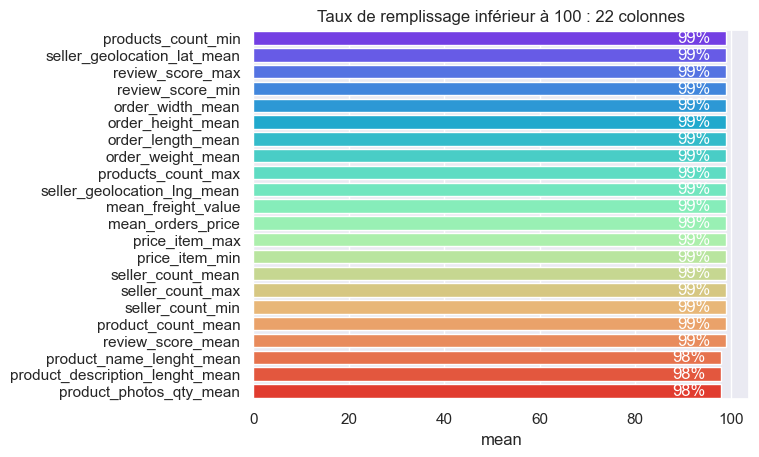

In [44]:
remplissage(DF_MAIN, 100)

In [45]:
DF_MAIN.shape

(96096, 151)

In [46]:
DF_MAIN.dropna().shape

(92958, 151)

On ne perd que 3.2% du dataset en supprimant les enregitrement incomplets

In [47]:
DF_MAIN.dropna(inplace=True)

In [48]:
DF_MAIN.describe()

,orders_count,customer_geolocation_lat_mean,customer_geolocation_lat_count,customer_geolocation_lat_most_frequent,customer_geolocation_lng_mean,customer_geolocation_lng_count,customer_geolocation_lng_most_frequent,order_purchase_timestamp_min,order_purchase_timestamp_max,products_count_min,products_count_max,product_count_mean,seller_count_min,seller_count_max,seller_count_mean,price_item_min,price_item_max,total_orders_price,mean_orders_price,total_freight_value,mean_freight_value,seller_geolocation_lat_mean,seller_geolocation_lng_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,order_weight_mean,order_length_mean,order_height_mean,order_width_mean,payment_sequential_mean,payment_installments_mean,payment_value_sum,review_score_min,review_score_max,review_score_mean,purchase_days_from_today_min,purchase_days_from_today_max,purchase_days_from_today_mean,cat_agro_industria_e_comercio_count,cat_alimentos_count,cat_alimentos_bebidas_count,cat_artes_count,cat_artes_e_artesanato_count,cat_artigos_de_festas_count,cat_artigos_de_natal_count,cat_audio_count,cat_automotivo_count,cat_bebes_count,cat_bebidas_count,cat_beleza_saude_count,cat_brinquedos_count,cat_cama_mesa_banho_count,cat_casa_conforto_count,cat_casa_conforto_2_count,cat_casa_construcao_count,cat_cds_dvds_musicais_count,cat_cine_foto_count,cat_climatizacao_count,cat_consoles_games_count,cat_construcao_ferramentas_construcao_count,cat_construcao_ferramentas_ferramentas_count,cat_construcao_ferramentas_iluminacao_count,cat_construcao_ferramentas_jardim_count,cat_construcao_ferramentas_seguranca_count,cat_cool_stuff_count,cat_dvds_blu_ray_count,cat_eletrodomesticos_count,cat_eletrodomesticos_2_count,cat_eletronicos_count,cat_eletroportateis_count,cat_esporte_lazer_count,cat_fashion_bolsas_e_acessorios_count,cat_fashion_calcados_count,cat_fashion_esporte_count,cat_fashion_roupa_feminina_count,cat_fashion_roupa_infanto_juvenil_count,cat_fashion_roupa_masculina_count,cat_fashion_underwear_e_moda_praia_count,cat_ferramentas_jardim_count,cat_flores_count,cat_fraldas_higiene_count,cat_industria_comercio_e_negocios_count,cat_informatica_acessorios_count,cat_instrumentos_musicais_count,cat_la_cuisine_count,cat_livros_importados_count,cat_livros_interesse_geral_count,cat_livros_tecnicos_count,cat_malas_acessorios_count,cat_market_place_count,cat_moveis_colchao_e_estofado_count,cat_moveis_cozinha_area_de_servico_jantar_e_jardim_count,cat_moveis_decoracao_count,cat_moveis_escritorio_count,cat_moveis_quarto_count,cat_moveis_sala_count,cat_musica_count,cat_papelaria_count,cat_pc_gamer_count,cat_pcs_count,cat_perfumaria_count,cat_pet_shop_count,cat_portateis_casa_forno_e_cafe_count,cat_portateis_cozinha_e_preparadores_de_alimentos_count,cat_relogios_presentes_count,cat_seguros_e_servicos_count,cat_sinalizacao_e_seguranca_count,cat_tablets_impressao_imagem_count,cat_telefonia_count,cat_telefonia_fixa_count,cat_utilidades_domesticas_count,payment_type_boleto_count,payment_type_credit_card_count,payment_type_debit_card_count,payment_type_not_defined_count,payment_type_voucher_count,order_status_approved_count,order_status_canceled_count,order_status_created_count,order_status_delivered_count,order_status_invoiced_count,order_status_processing_count,order_status_shipped_count,order_status_unavailable_count,purchase_year_2016_count,purchase_year_2017_count,purchase_year_2018_count,purchase_month_1_count,purchase_month_2_count,purchase_month_3_count,purchase_month_4_count,purchase_month_5_count,purchase_month_6_count,purchase_month_7_count,purchase_month_8_count,purchase_month_9_count,purchase_month_10_count,purchase_month_11_count,purchase_month_12_count,purchase_quarter_1_count,purchase_quarter_2_count,purchase_quarter_3_count,purchase_quarter_4_count,purchase_day_of_week_0_count,purchase_day_of_week_1_count,purchase_day_of_week_2_count,purchase_day_of_week_3_count,purchase_day_of_week_4_count,purchase_day_of_week_5_count,purchase_day_of_week_6_count
count,

## Correlations

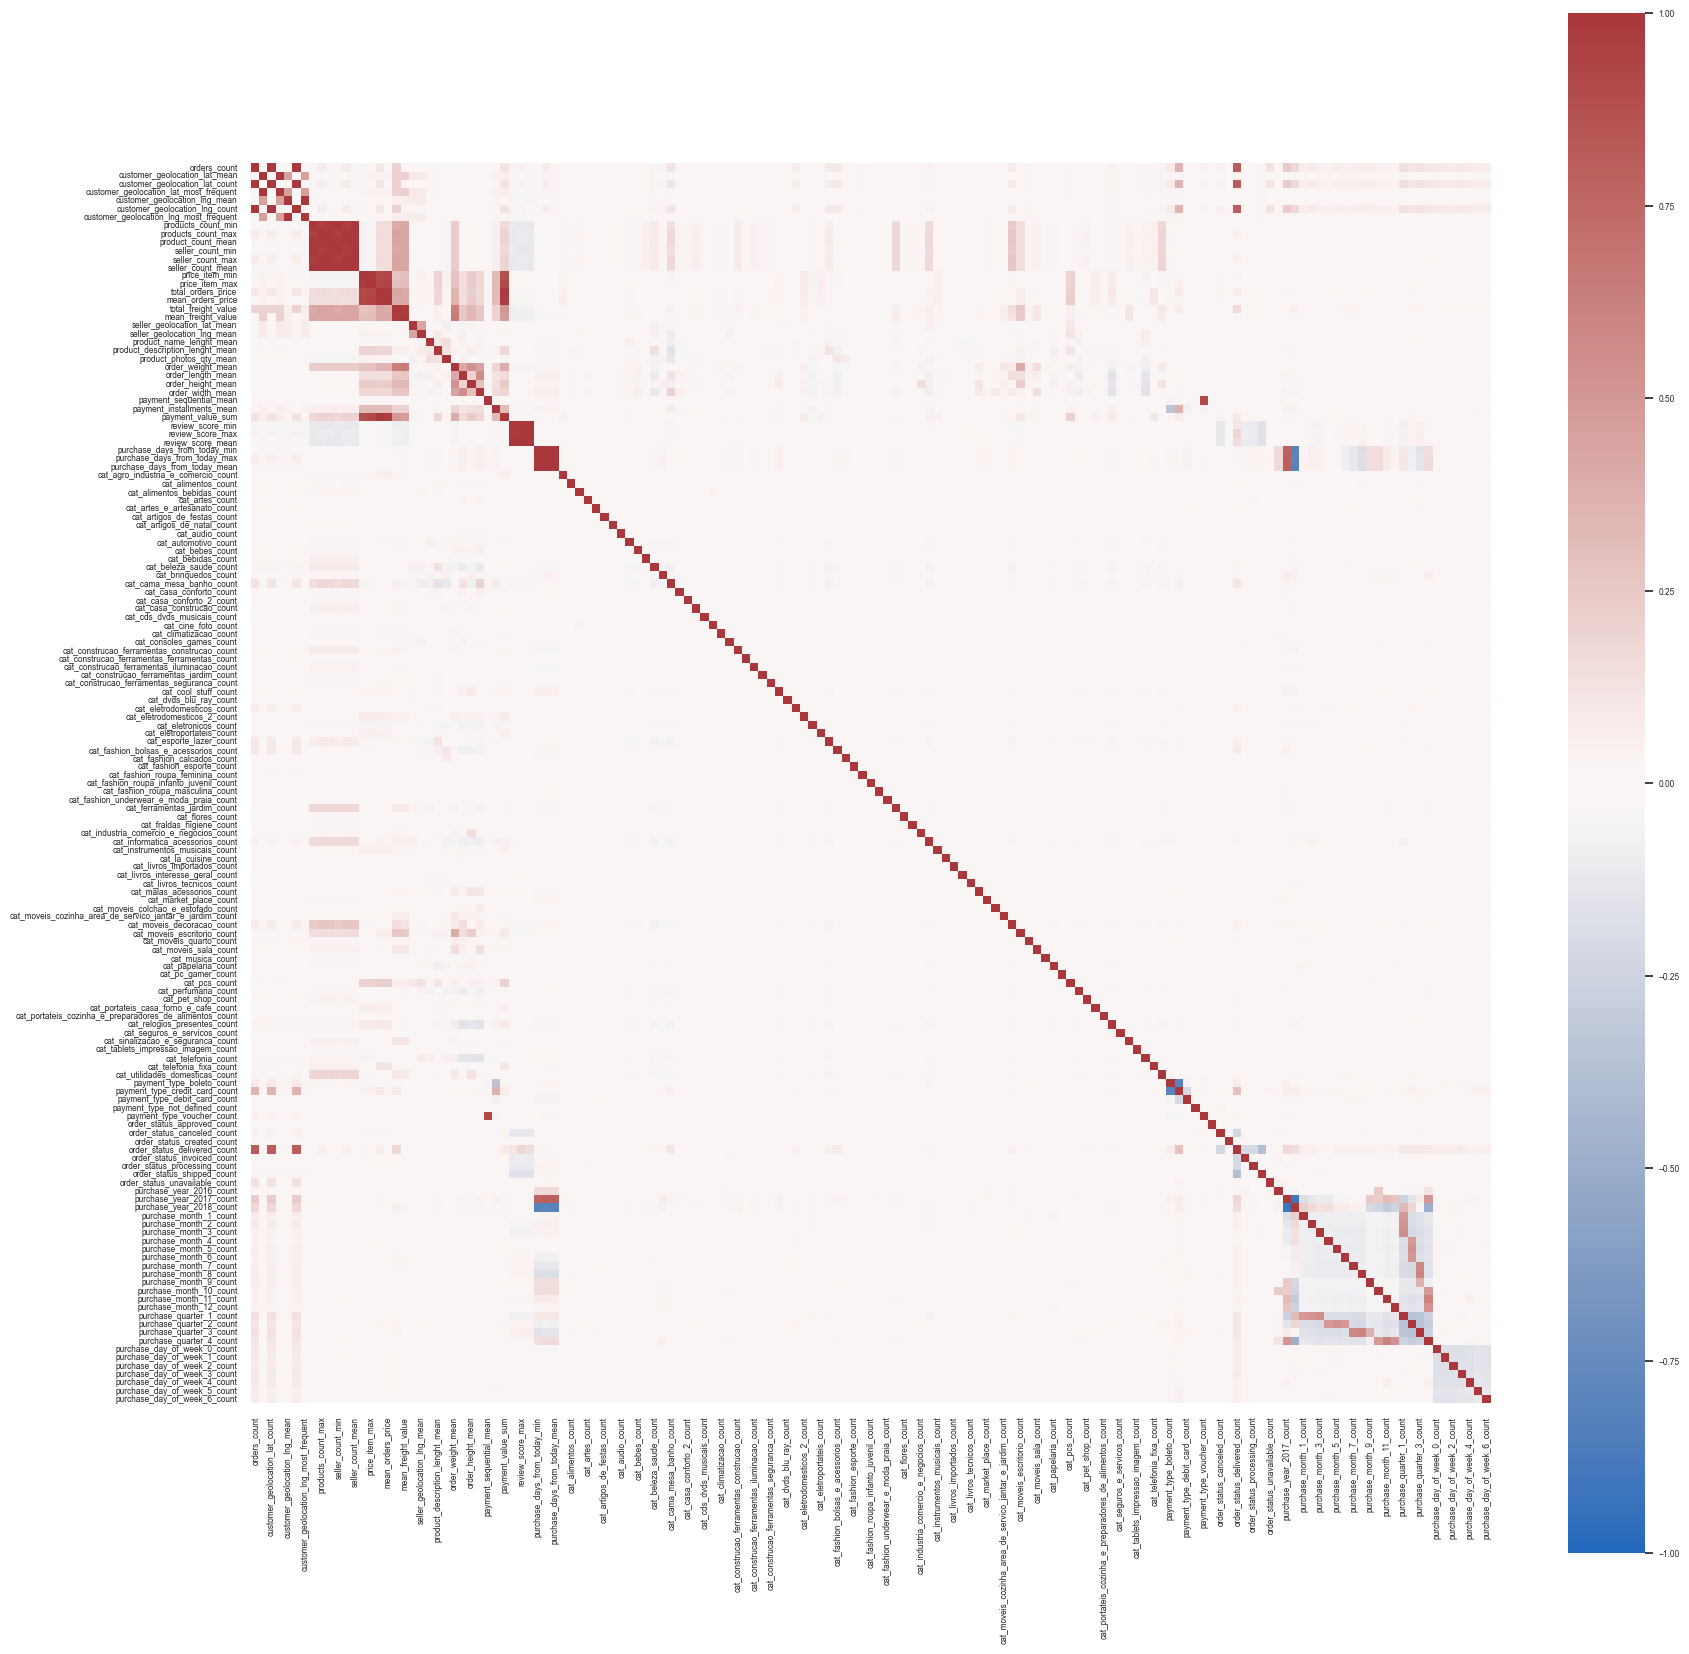

In [49]:
fig = plt.figure(figsize=(20,20))
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)
corr = DF_MAIN.corr(numeric_only=True)
ax = sns.heatmap(corr, square=True, cmap='vlag', vmax=1, vmin=-1, )

## Analyse des répartitions

### Commandes, produits, vendeurs et prix

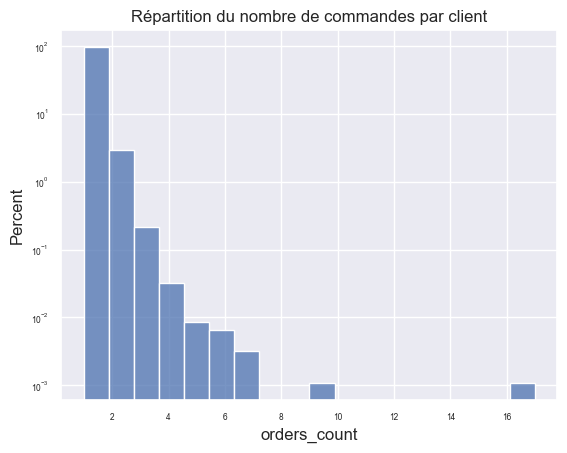

In [50]:
ax = sns.histplot(data=DF_MAIN, x='orders_count',log_scale=(False,True), stat='percent')
ax.set(title='Répartition du nombre de commandes par client')
plt.show()

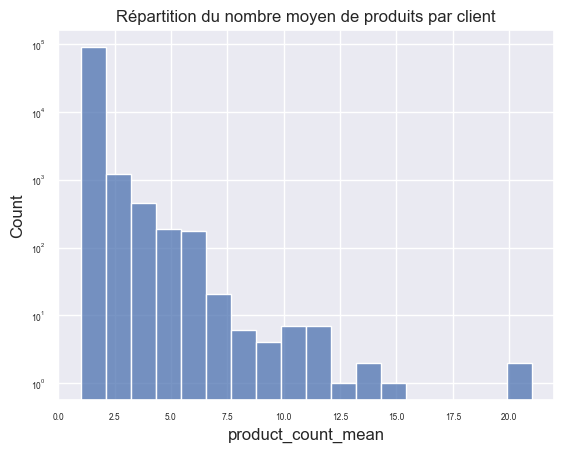

In [51]:
ax = sns.histplot(data=DF_MAIN, x='product_count_mean', log_scale=(False,True))
ax.set(title='Répartition du nombre moyen de produits par client')
plt.show()

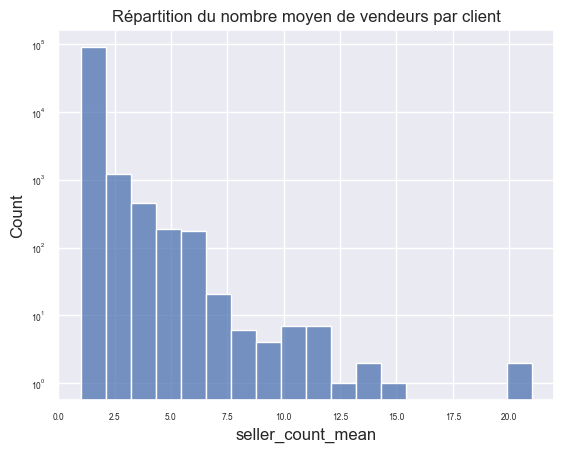

In [52]:
ax = sns.histplot(data=DF_MAIN, x='seller_count_mean', log_scale=(False,True))
ax.set(title='Répartition du nombre moyen de vendeurs par client')
plt.show()

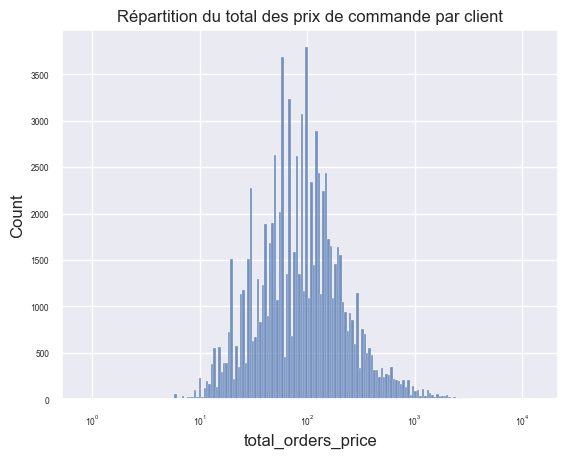

In [53]:
ax = sns.histplot(data=DF_MAIN, x='total_orders_price', log_scale=(True,False))
ax.set(title='Répartition du total des prix de commande par client')
plt.show()

### Géographique

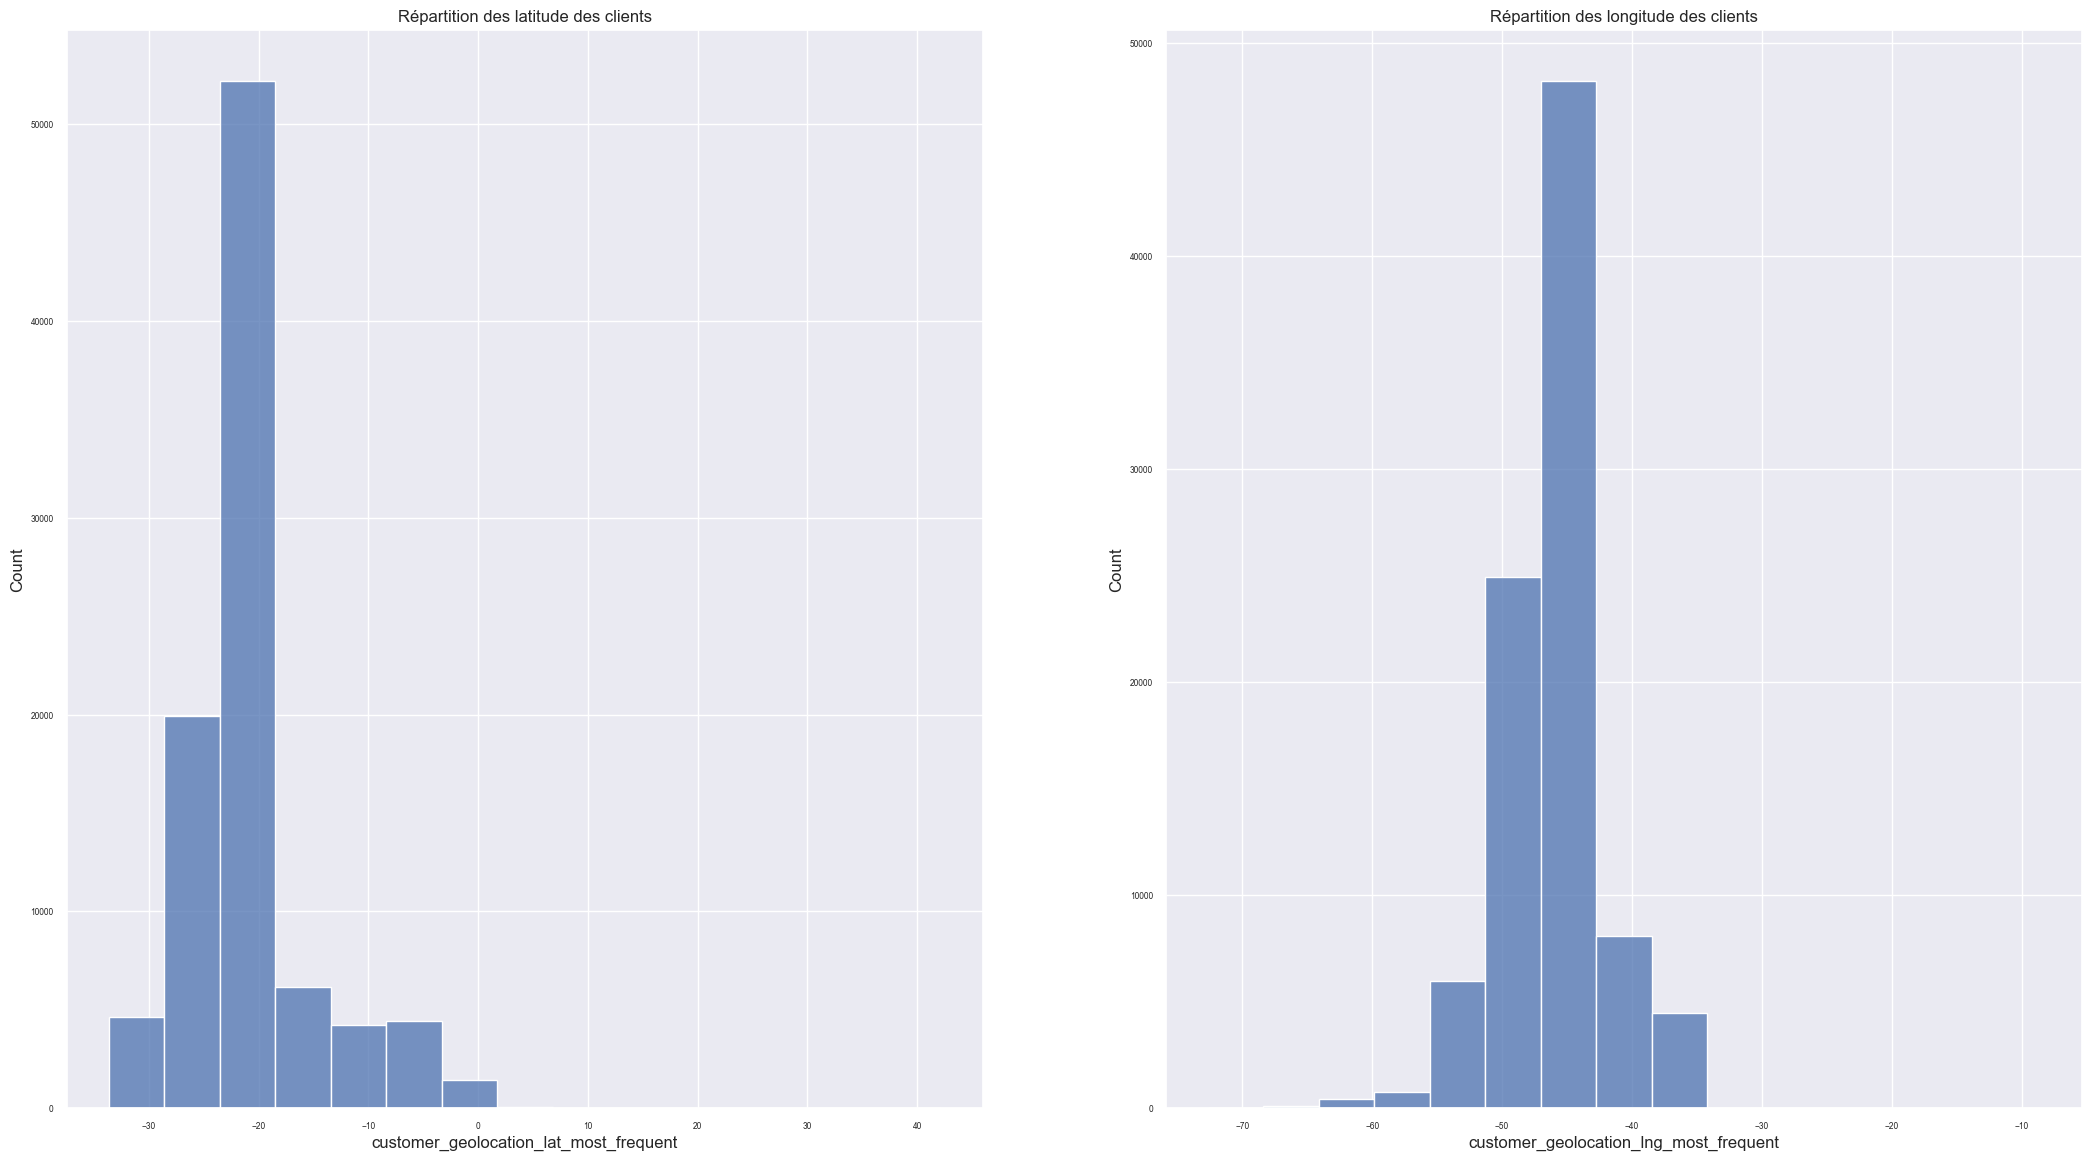

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))
ax1 = sns.histplot(data=DF_MAIN, x='customer_geolocation_lat_most_frequent', bins=15, ax=ax1)
ax1.set(title='Répartition des latitude des clients')
ax2 = sns.histplot(data=DF_MAIN, x='customer_geolocation_lng_most_frequent', bins=15, ax=ax2)
ax2.set(title='Répartition des longitude des clients')
plt.show()

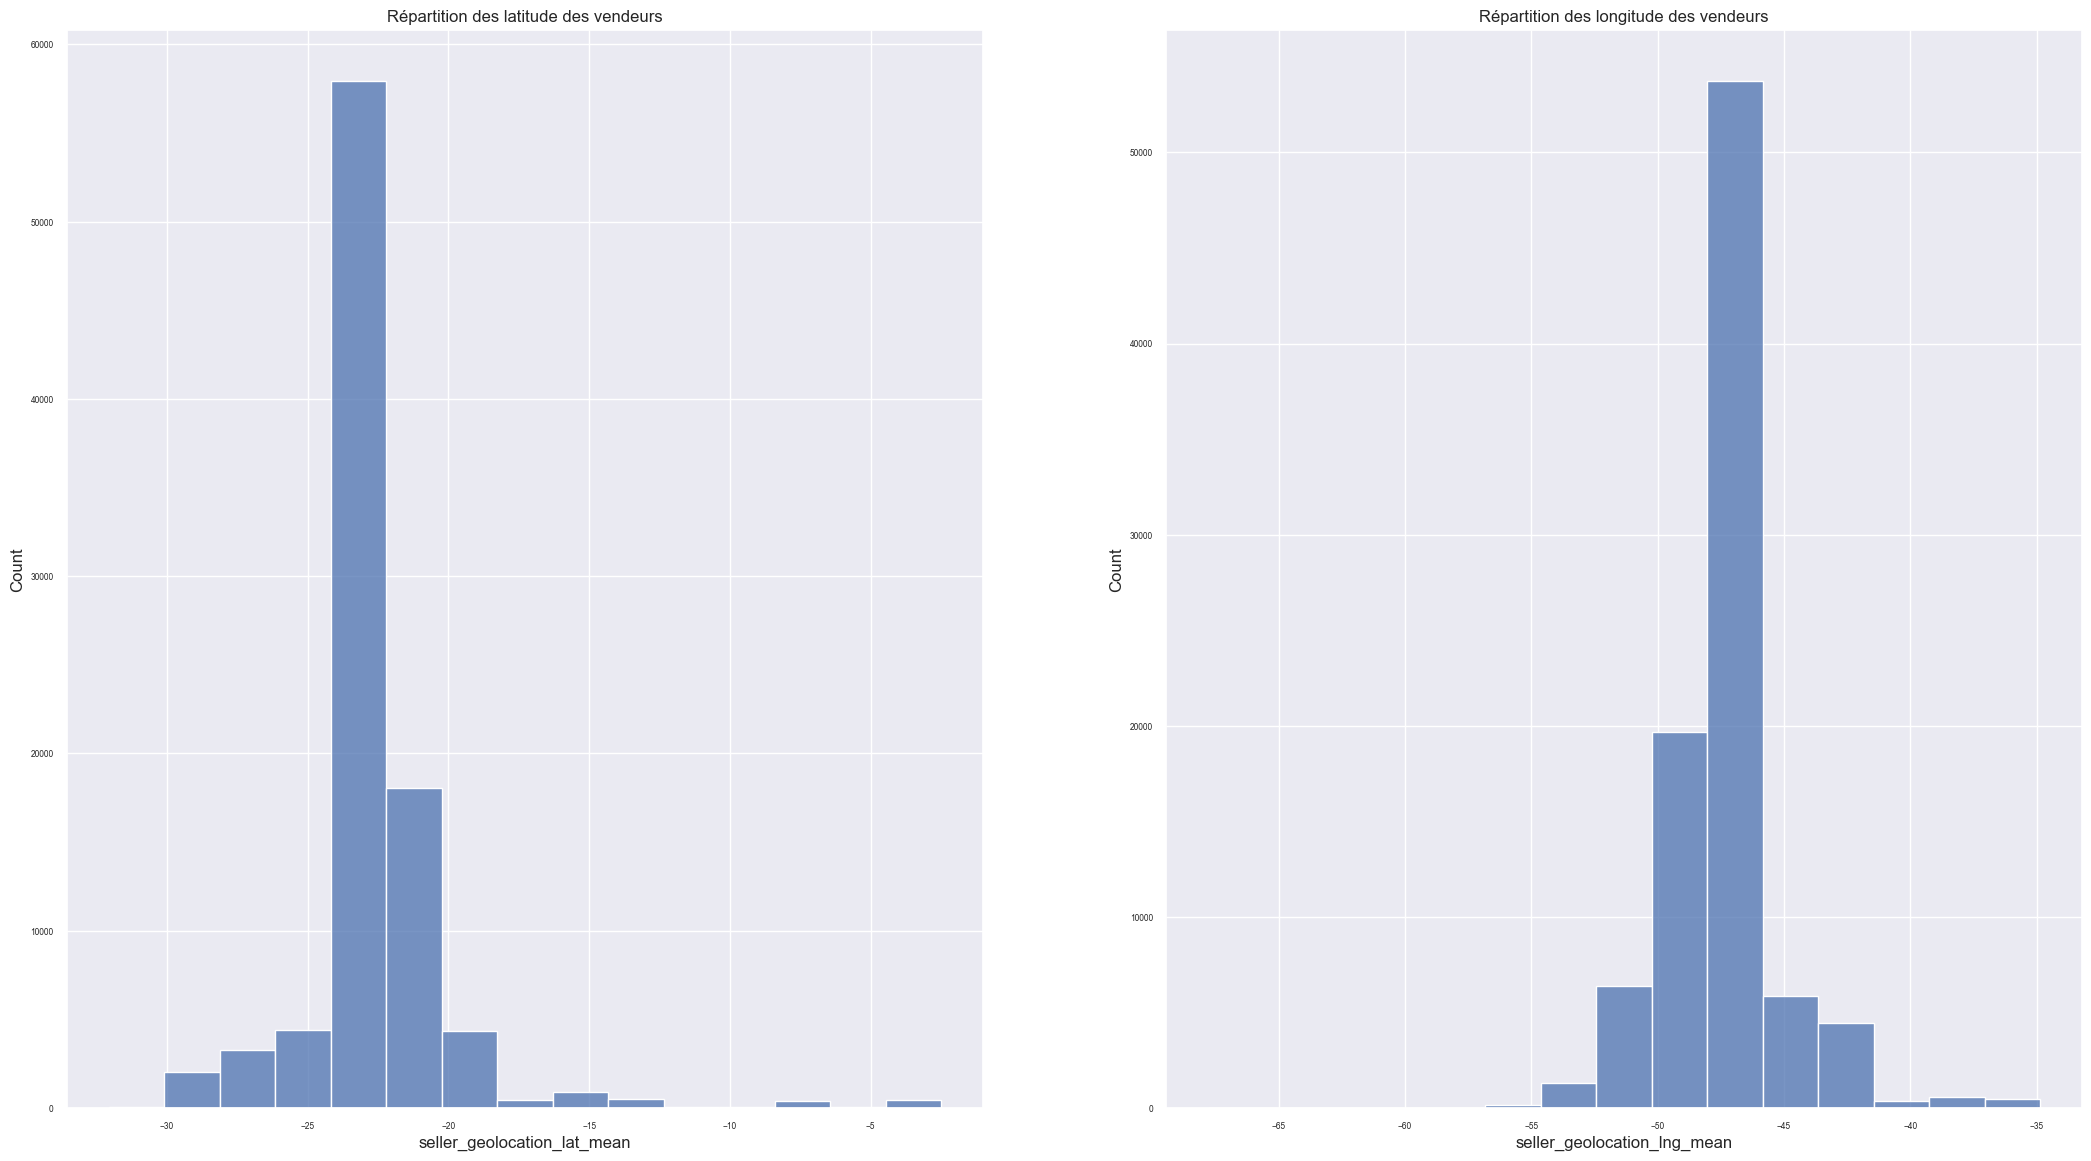

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))
ax1 = sns.histplot(data=DF_MAIN, x='seller_geolocation_lat_mean', bins=15, ax=ax1)
ax1.set(title='Répartition des latitude des vendeurs')
ax2 = sns.histplot(data=DF_MAIN, x='seller_geolocation_lng_mean', bins=15, ax=ax2)
ax2.set(title='Répartition des longitude des vendeurs')
plt.show()

### Dates

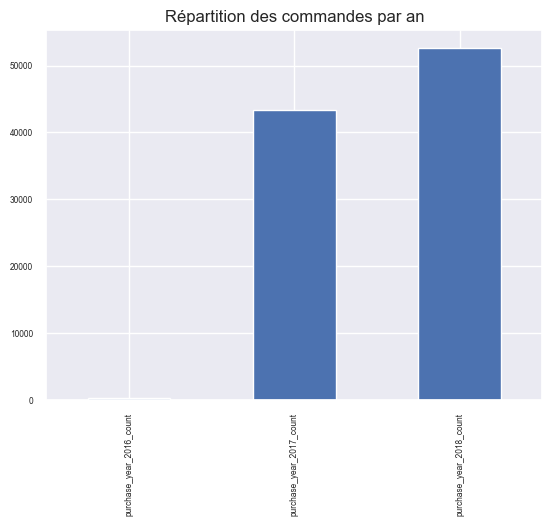

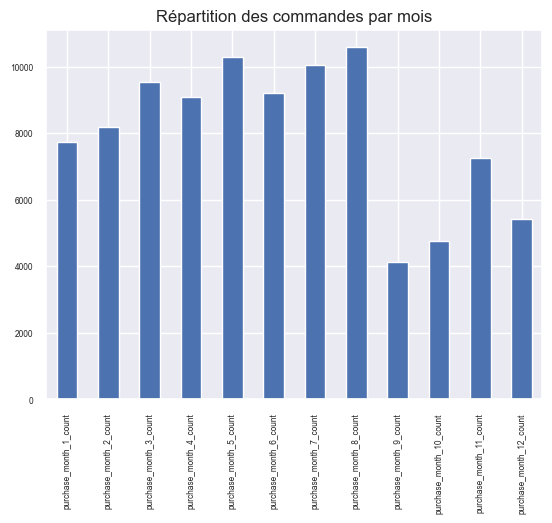

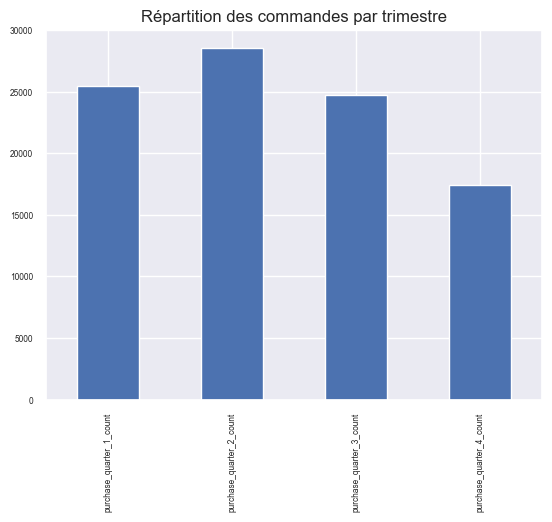

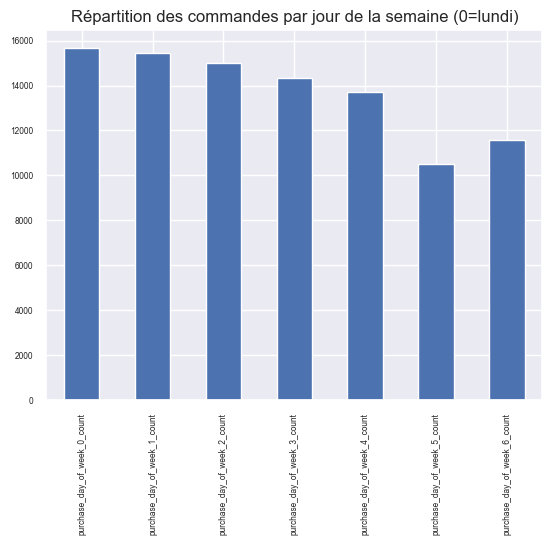

In [56]:
years = df_customers.columns[df_customers.columns.str.startswith('purchase_year_')].to_list()
months = df_customers.columns[df_customers.columns.str.startswith('purchase_month_')].to_list()
quarters = df_customers.columns[df_customers.columns.str.startswith('purchase_quarter_')].to_list()
day_of_week = df_customers.columns[df_customers.columns.str.startswith('purchase_day_of_week_')].to_list()

DF_MAIN.loc[:, years].sum().plot(kind='bar', title='Répartition des commandes par an')
plt.show()

DF_MAIN.loc[:, months].sum().plot(kind='bar', title='Répartition des commandes par mois')
plt.show()

DF_MAIN.loc[:, quarters].sum().plot(kind='bar', title='Répartition des commandes par trimestre')
plt.show()

DF_MAIN.loc[:, day_of_week].sum().plot(kind='bar', title='Répartition des commandes par jour de la semaine (0=lundi)')
plt.show()

### Catégories

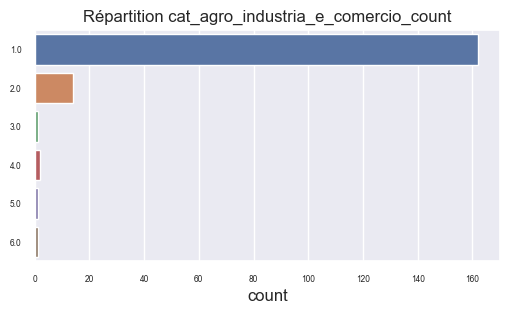

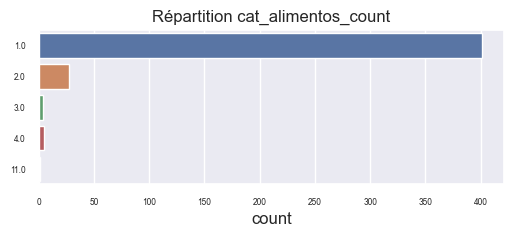

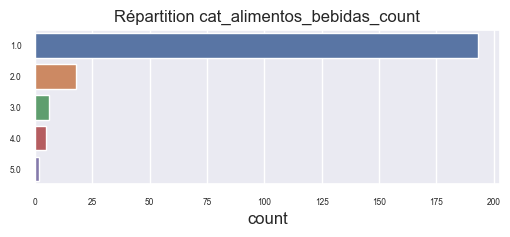

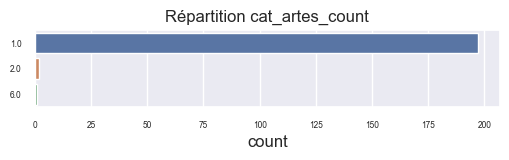

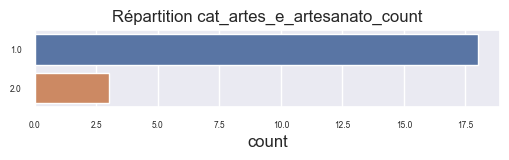

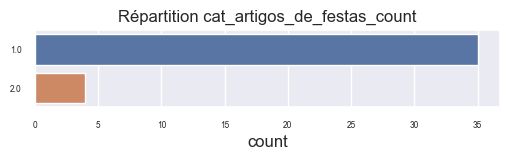

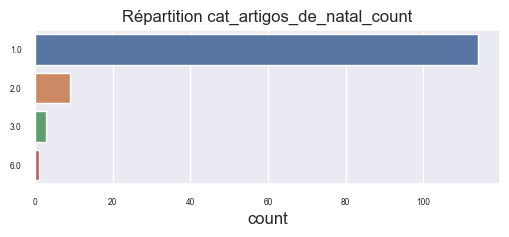

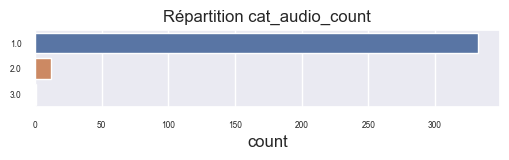

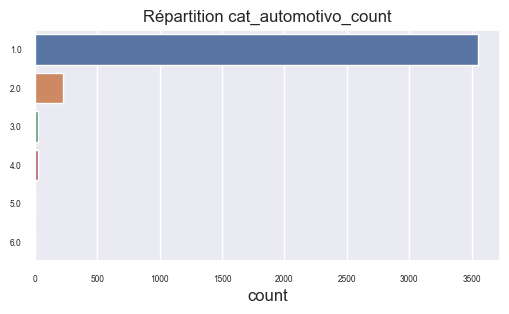

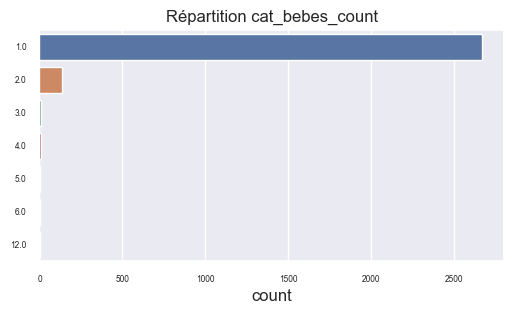

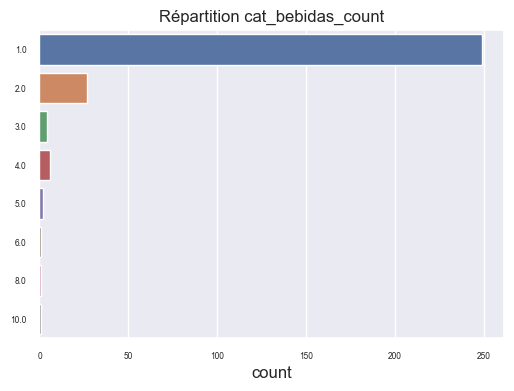

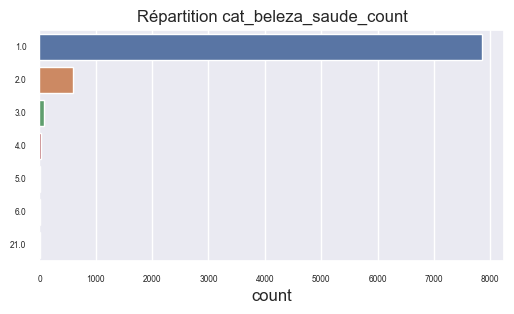

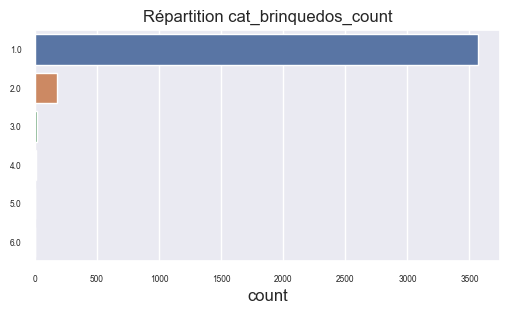

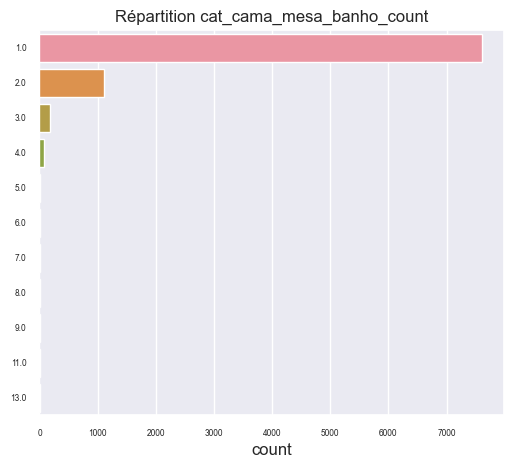

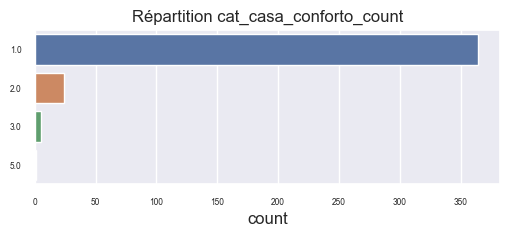

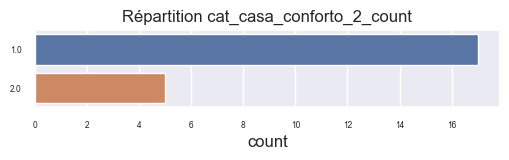

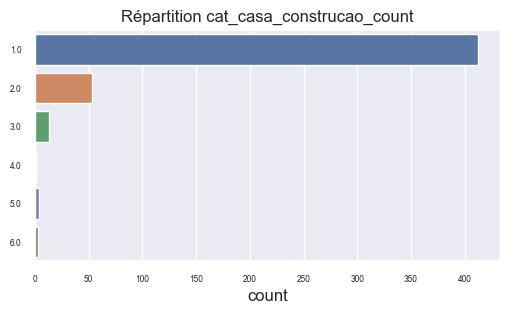

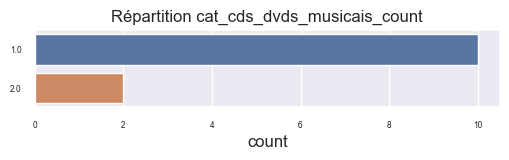

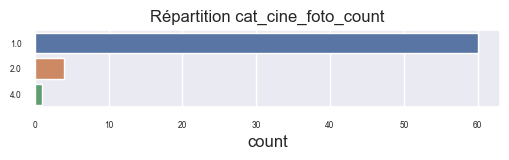

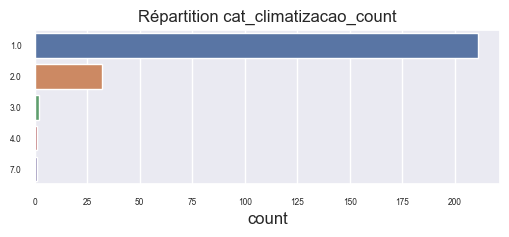

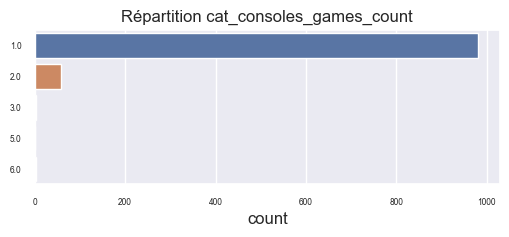

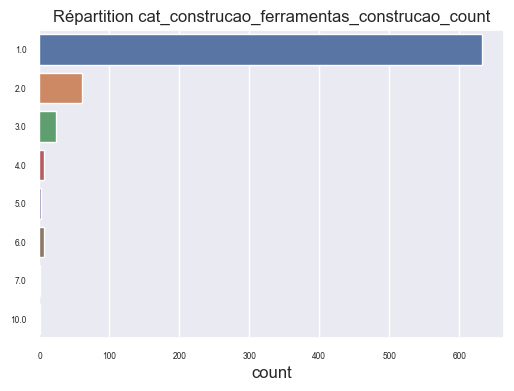

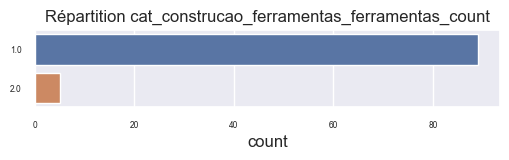

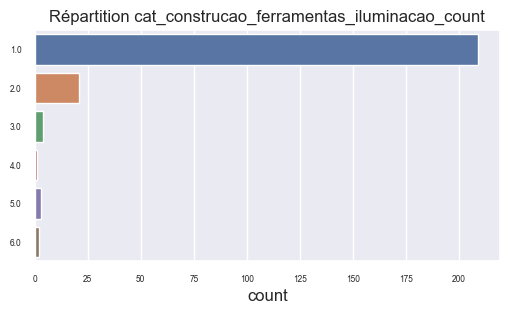

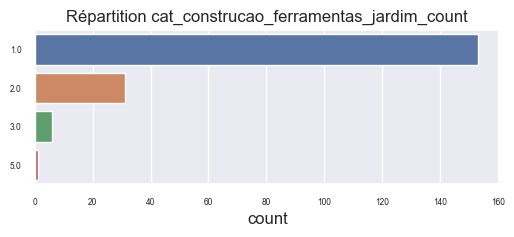

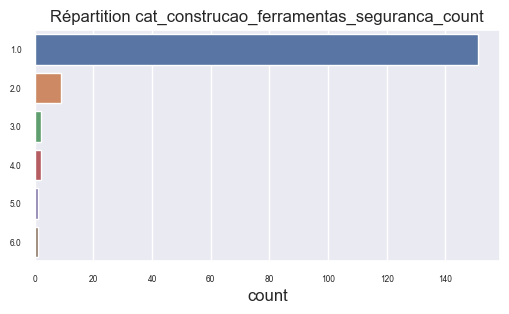

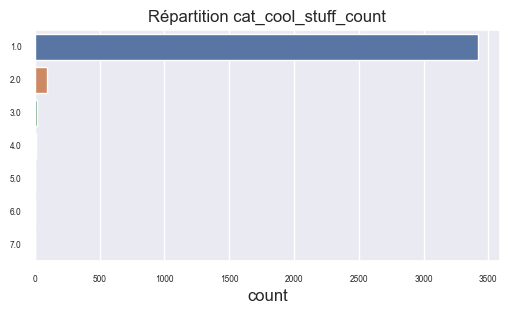

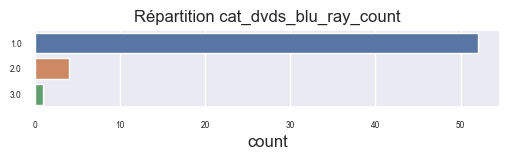

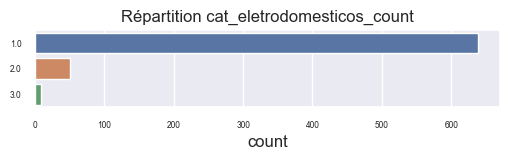

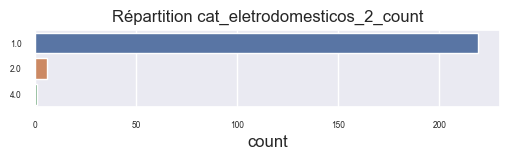

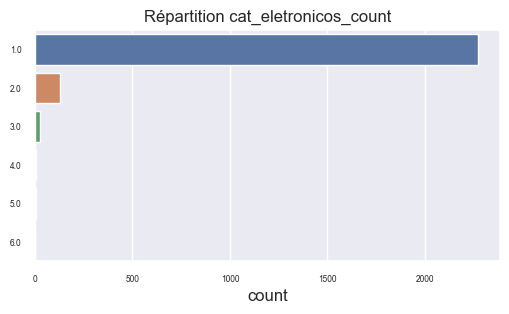

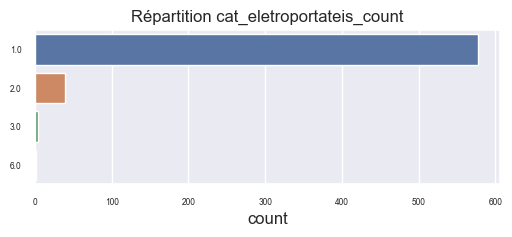

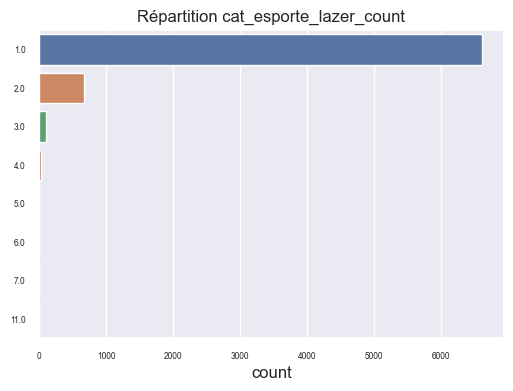

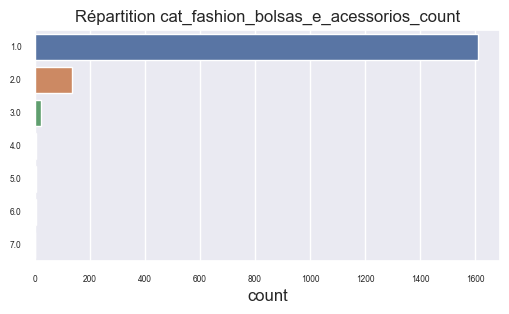

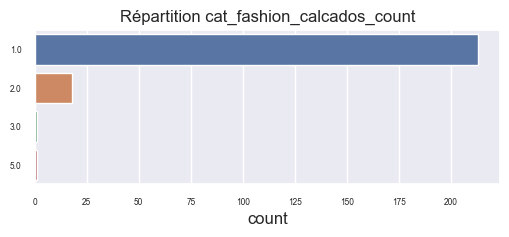

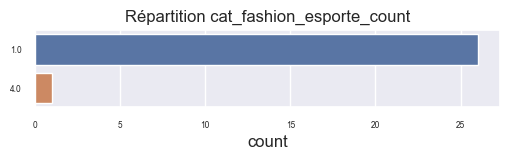

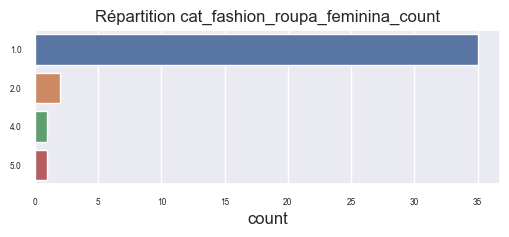

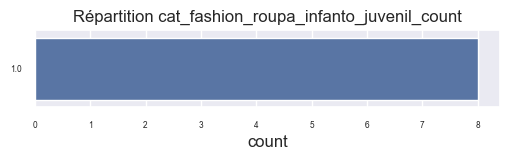

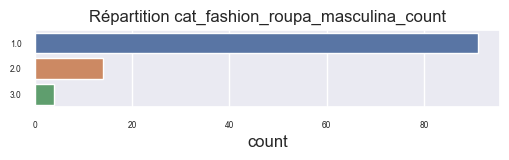

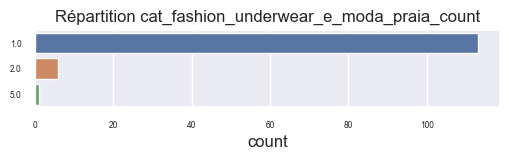

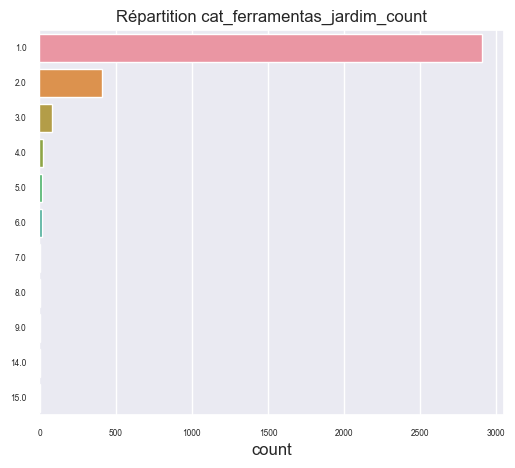

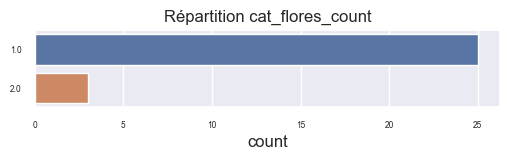

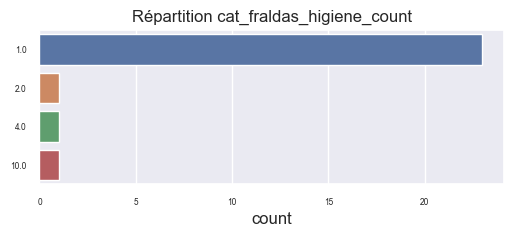

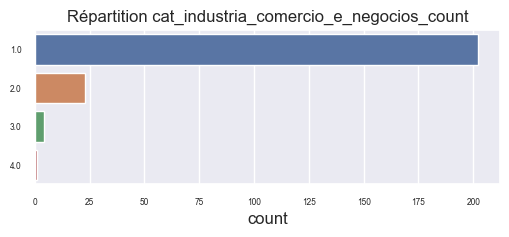

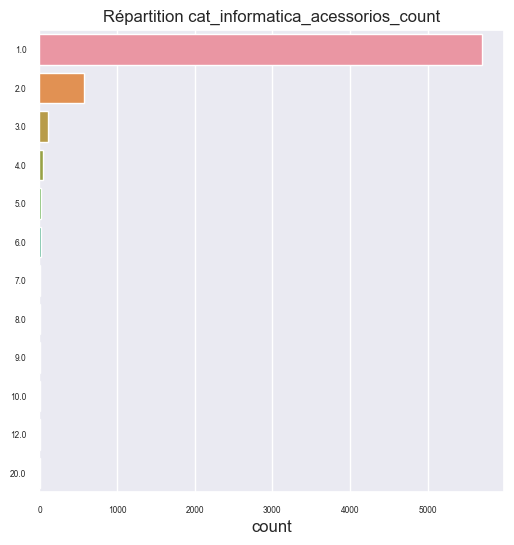

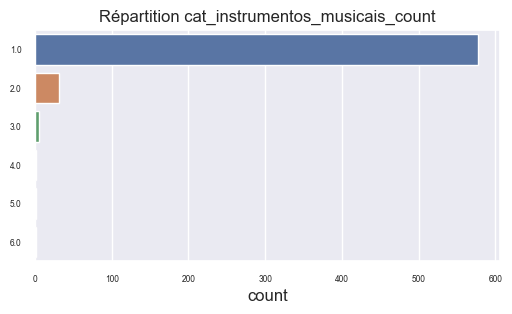

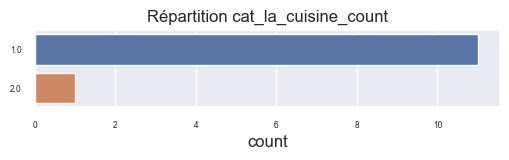

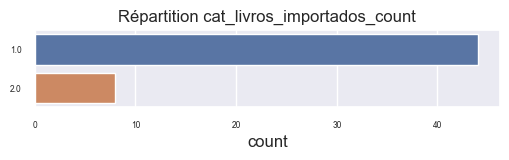

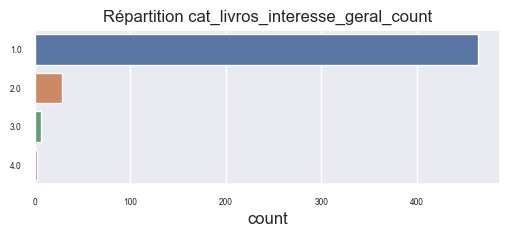

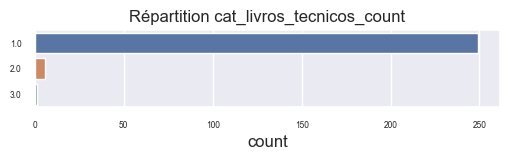

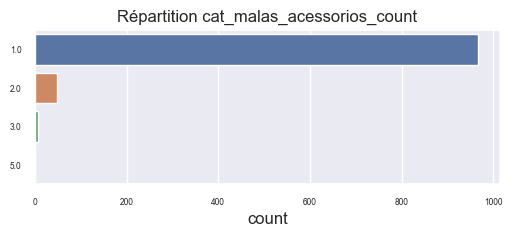

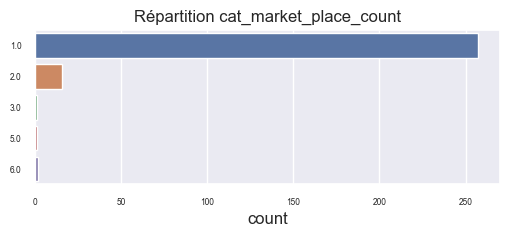

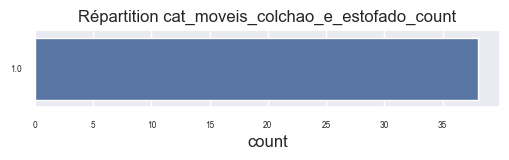

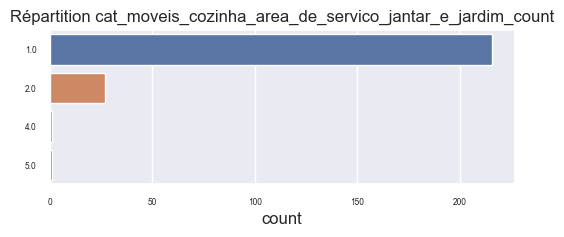

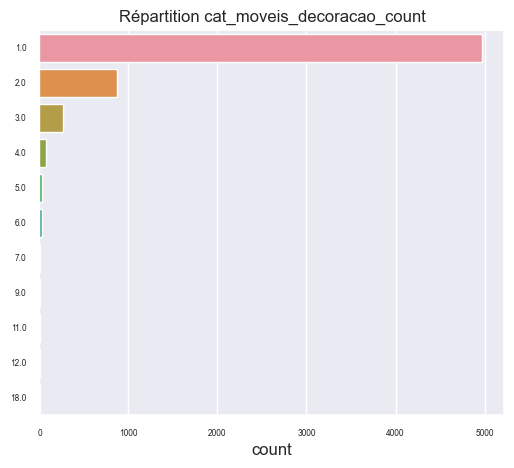

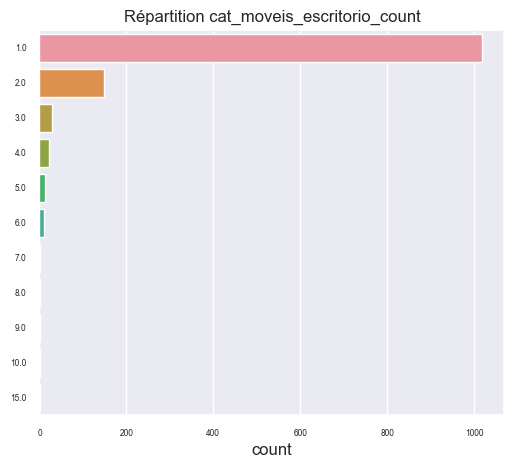

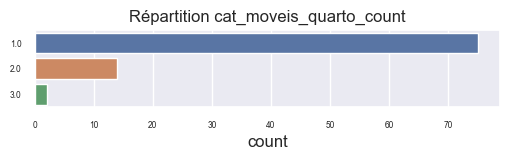

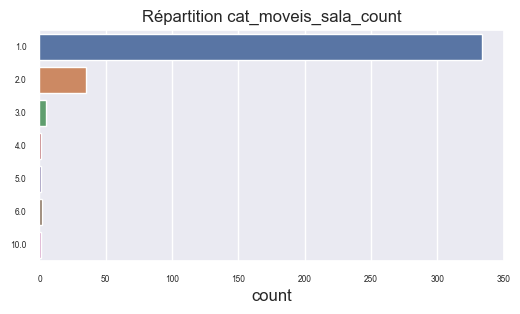

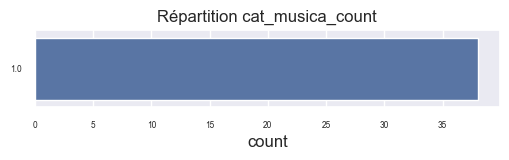

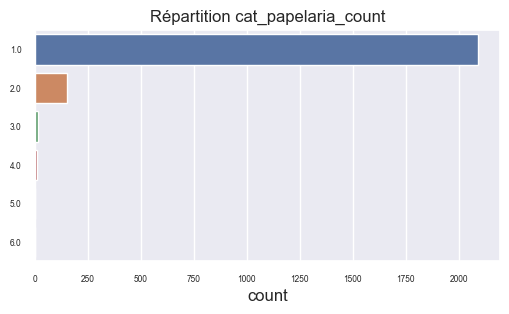

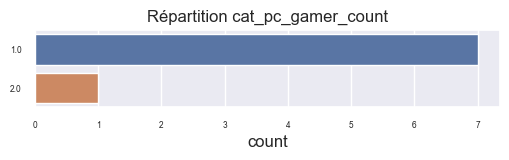

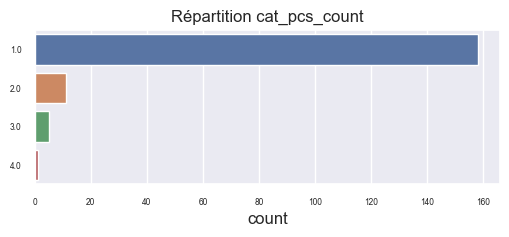

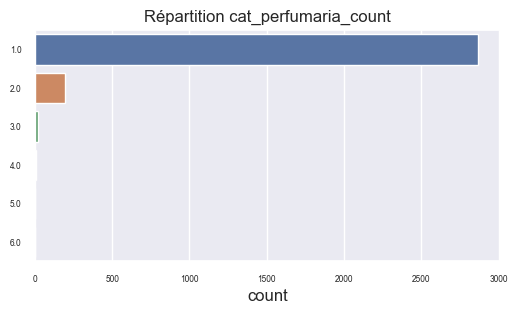

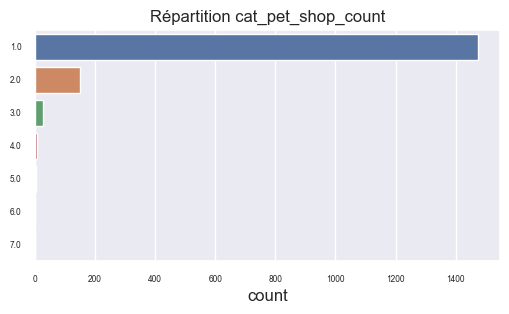

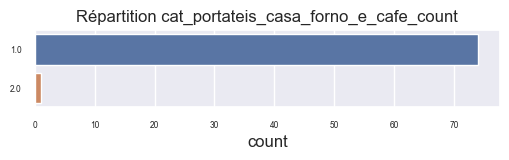

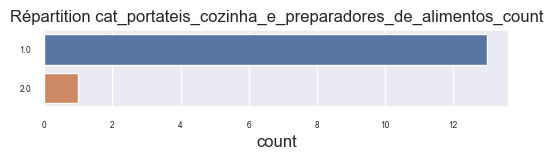

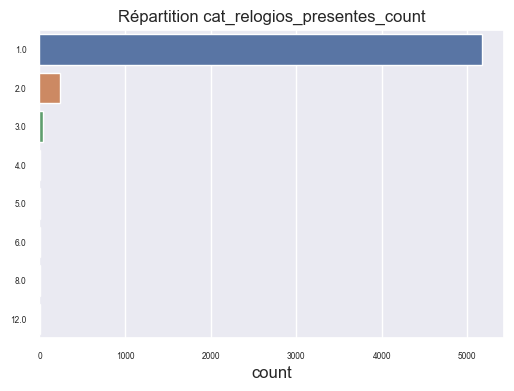

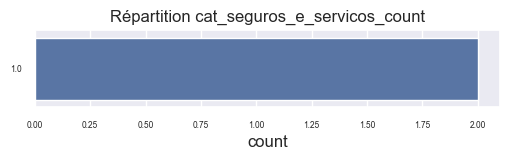

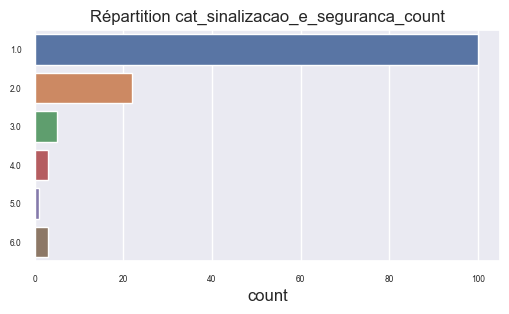

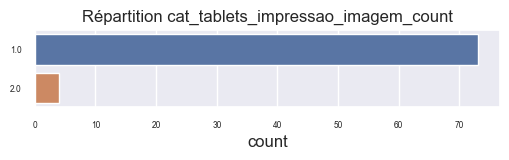

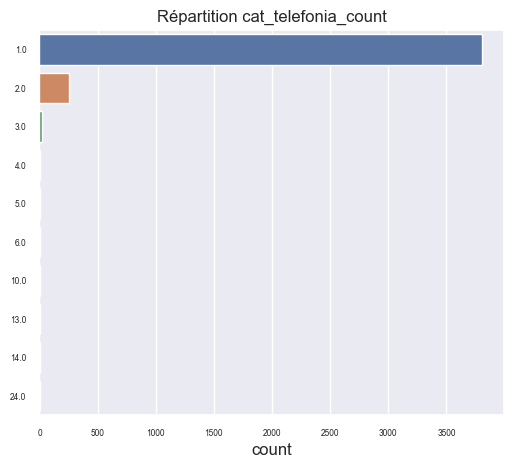

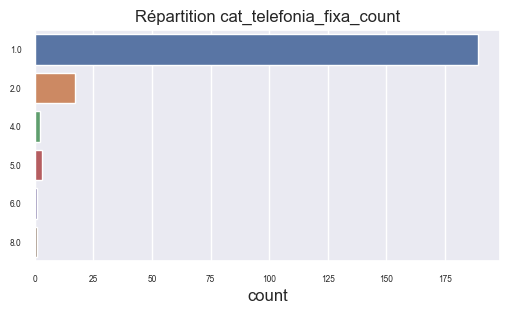

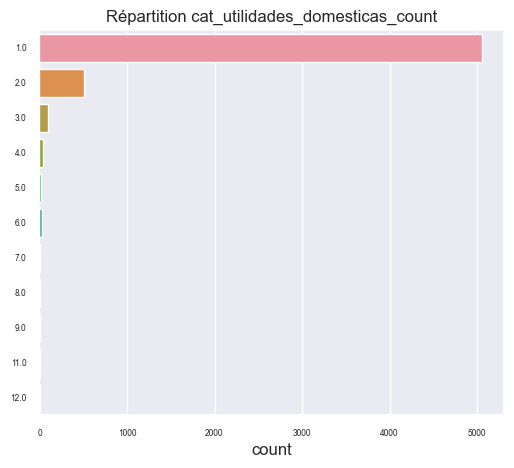

In [57]:
for cat in DF_MAIN.columns:
    if cat.startswith('cat_'):
        df_copy = pd.DataFrame()
        df_copy['cat_w0'] = DF_MAIN.loc[DF_MAIN[cat] > 0, cat]
        lng = len(df_copy['cat_w0'].unique())
        fig = plt.figure(figsize=(6,  max(1, lng//2)))
        ax = sns.countplot(data=df_copy, y='cat_w0')
        ax.set(title=f'Répartition {cat}')
        ax.set_ylabel('')
        plt.show()

### Reviews

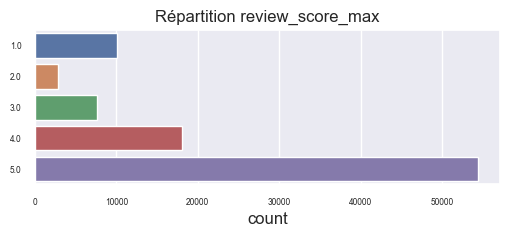

In [58]:
cat = 'review_score_max'
lng = len(DF_MAIN[cat].unique())
fig = plt.figure(figsize=(6,  max(1, lng//2)))
ax = sns.countplot(data=DF_MAIN, y=cat)
ax.set(title=f'Répartition {cat}')
ax.set_ylabel('')
plt.show()

# Enregistrement

In [59]:
DF_MAIN.to_pickle(ROOT_OUTPUT + 'olist_group_by_customer_unique_id.pickle')